In [1]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd
import scipy.stats as sc
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [2]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.head())
print(df_all_sorted.head())





astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1   
2  28859186       0  28859186   2217  263212       1   
3  32680807       0  32680807   4213  263212       1   
4  35023796       0  35023796    417  263213       1   

                                                  HG  \
0  [[2158, 2264, 2118, 2251, 2150, 2144, 2247, 22...   
1  [[2251, 2145, 2137, 2122, 2236, 2138, 2146, 22...   
2  [[2107, 2316, 2213, 2026, 2181, 2110, 2212, 21...

In [3]:
dt = np.diff(df_all_sorted["TIME_ABS"])
logdt = np.log10(np.where(dt > 0, dt, 1e-12))

#per adesso cerco vicino il taglio queipochi eventi avvenuti simultaneamente ma diversi
mask =  (logdt < 3.2)

df_dt = df_all_sorted.iloc[1:][mask]


#df_dt= df_all_sorted[ (np.log10(np.diff(df_all_sorted["TIME_ABS"]) < 3.2))]


#sono tanti, prendo i più energetici
df_dt['shape']= df_dt['HG'].apply(np.sum).to_numpy()
df_dt.sort_values('TIME_ABS',ascending=True, inplace=True)
df_dt.head()
print(df_dt["shape"].max())
print(df_dt["shape"].min())
print(len(df_dt))
#df_dt = df_dt[df_dt["shape"] > 5200425 ]
print(len(df_dt))

5480425
5129820
18897
18897


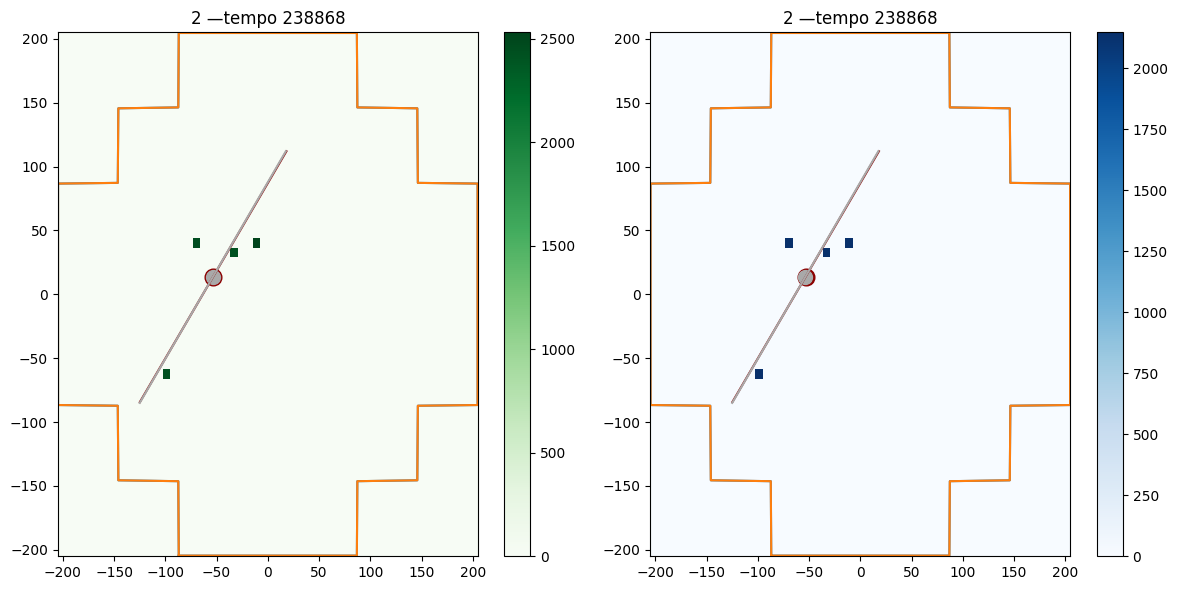

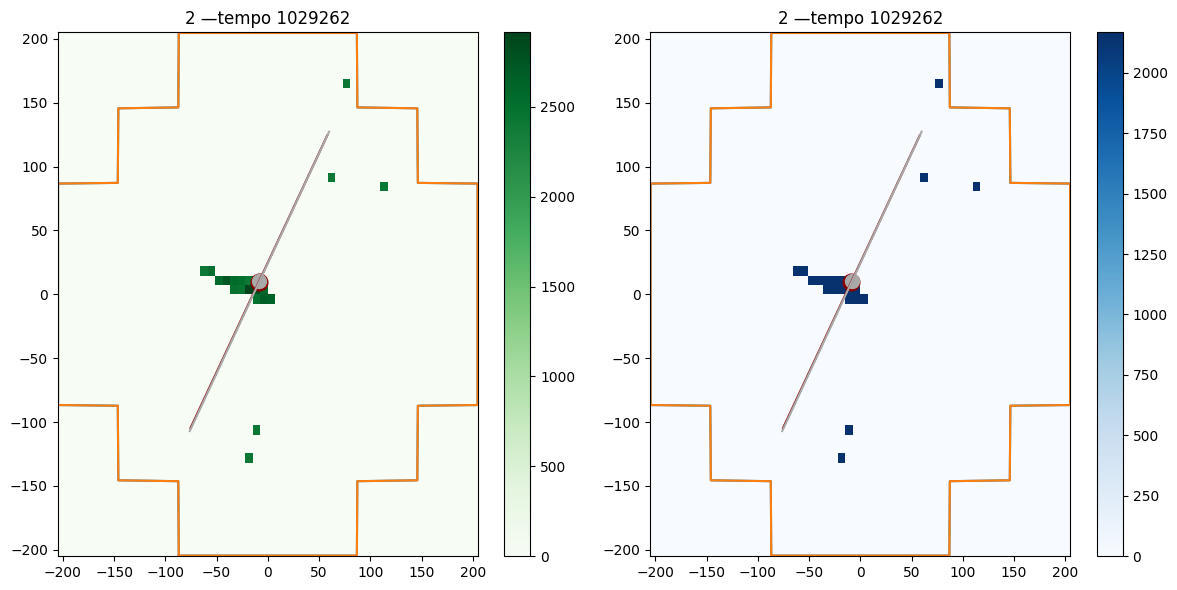

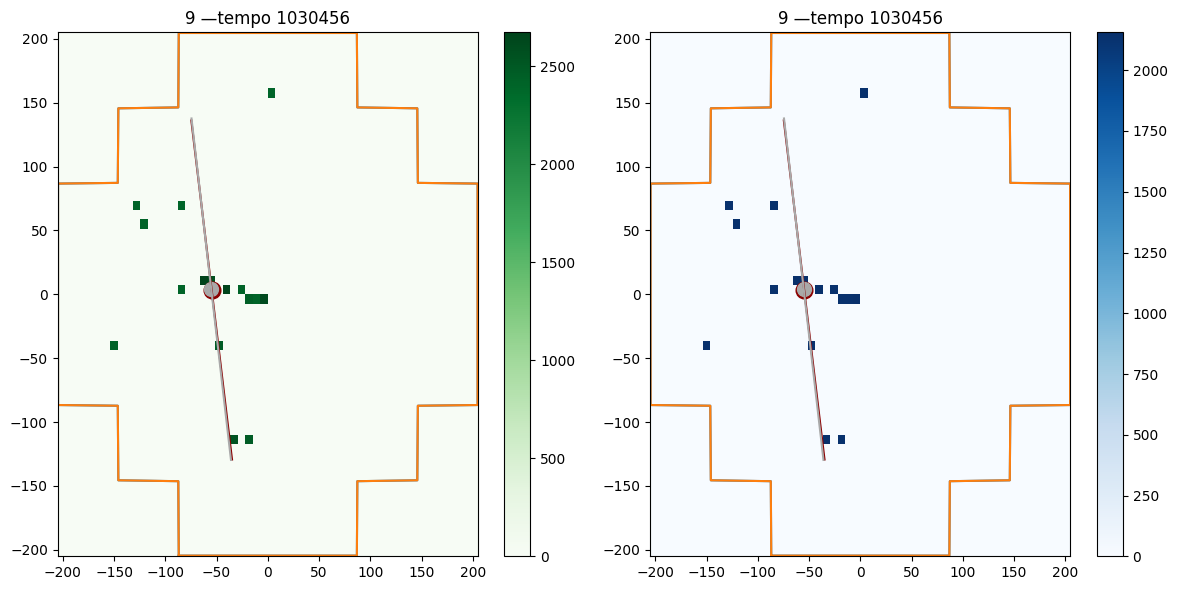

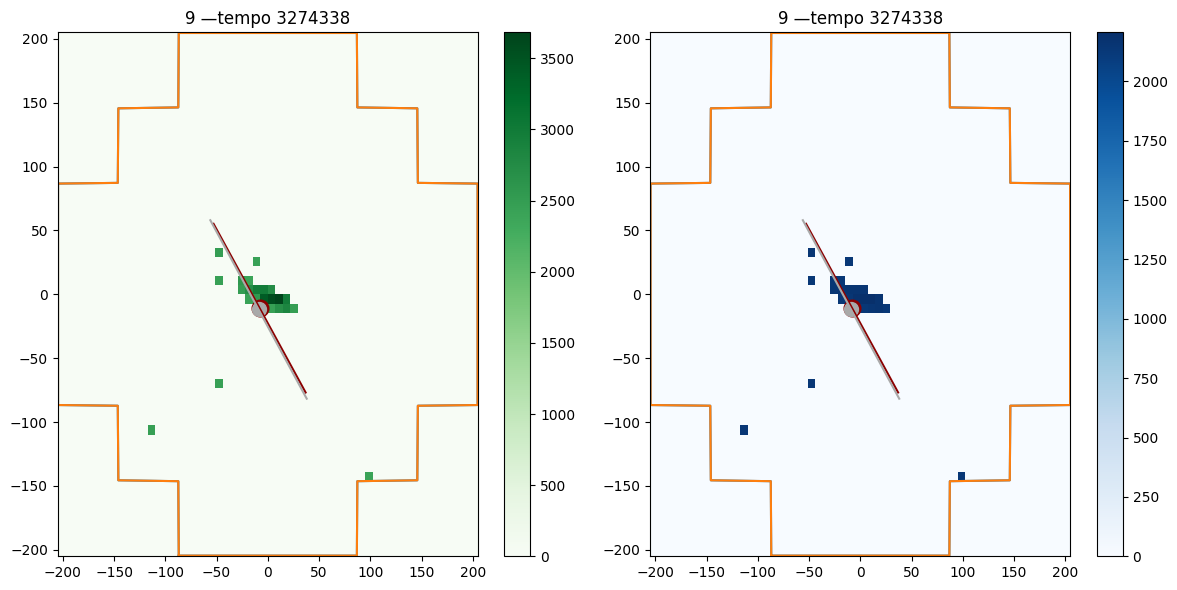

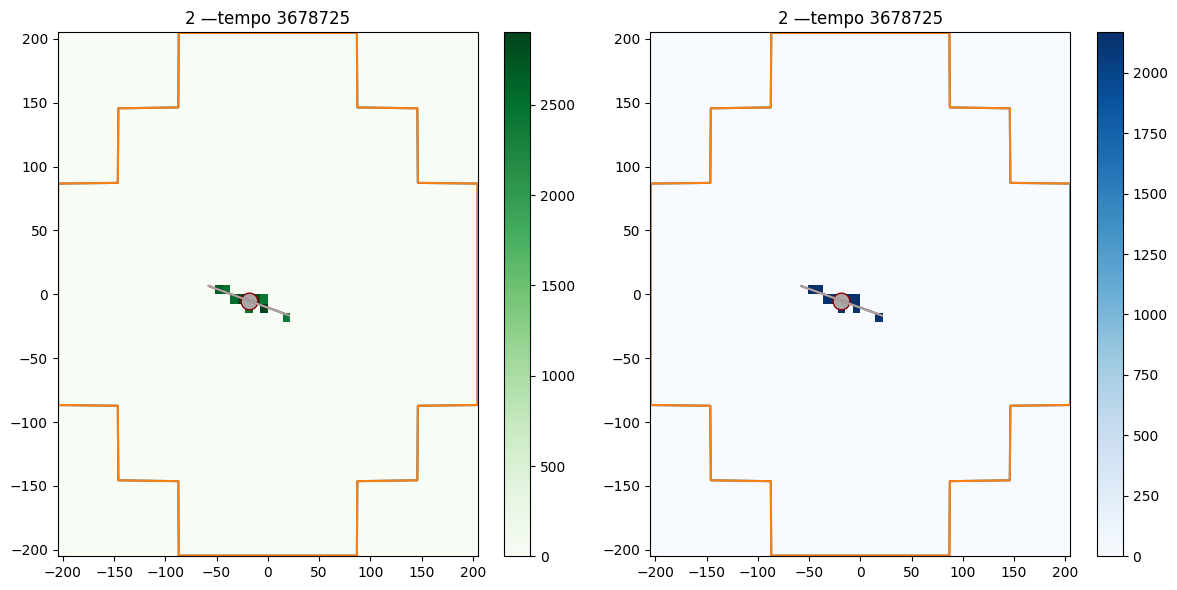

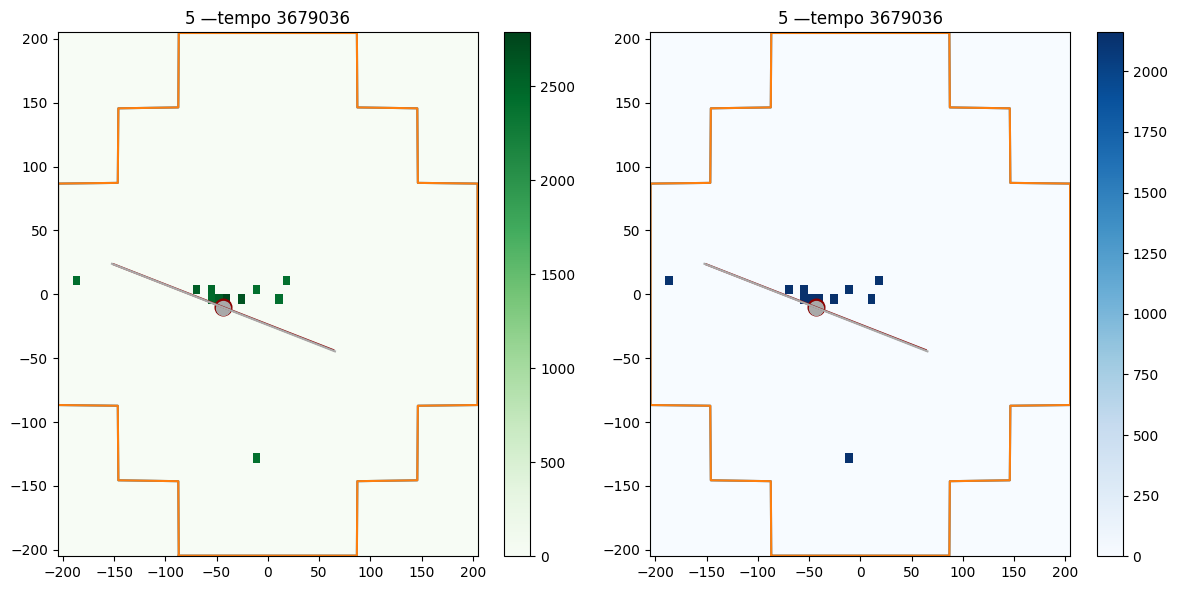

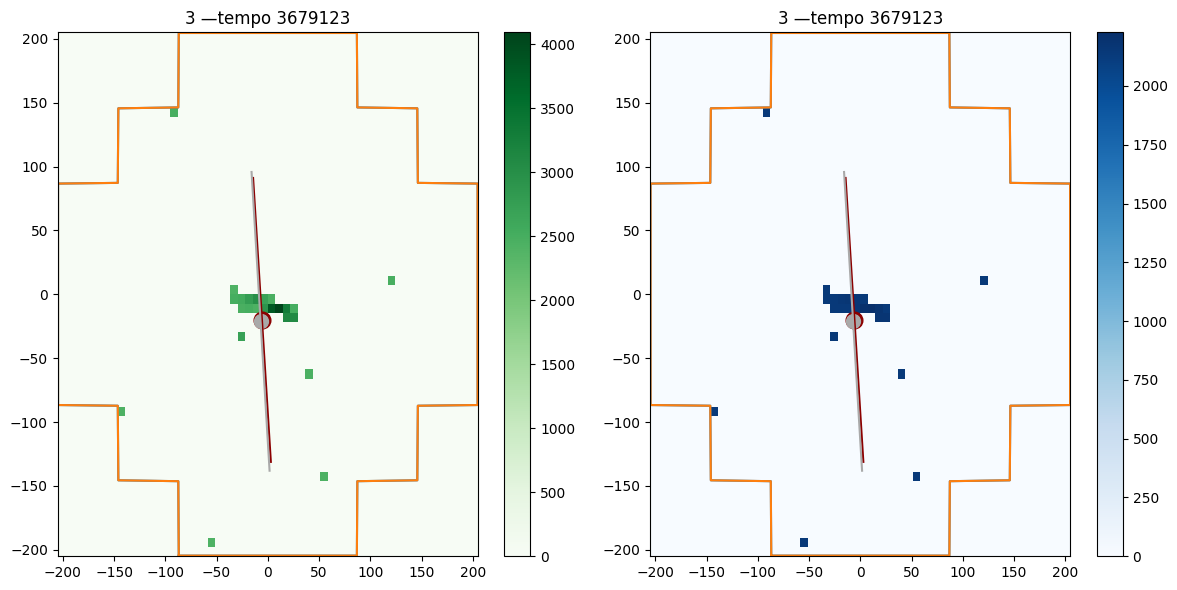

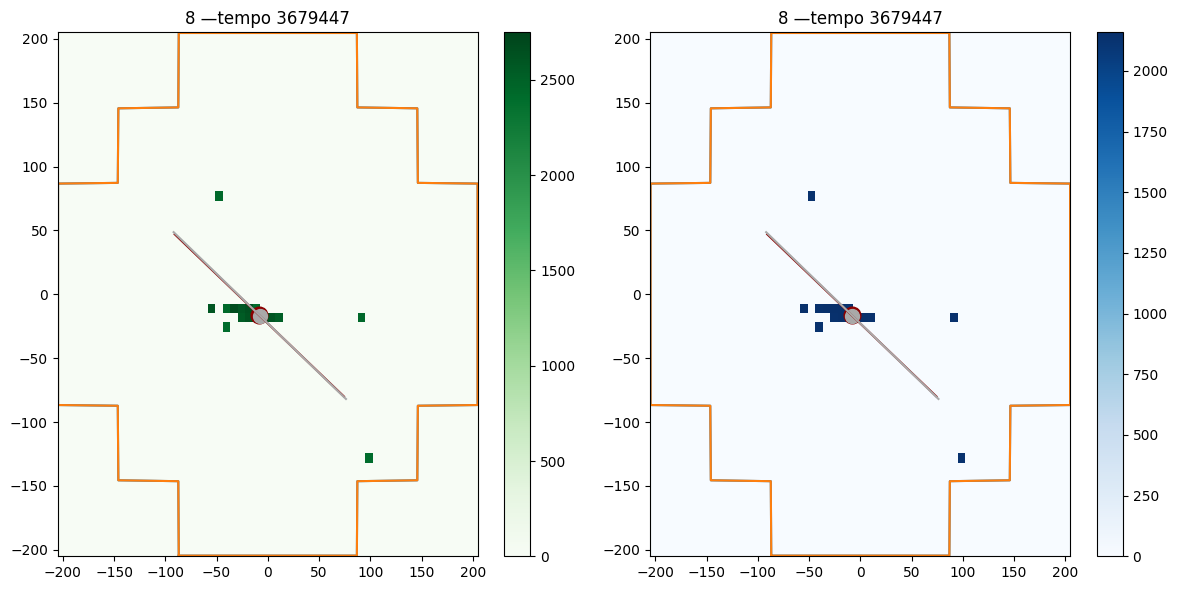

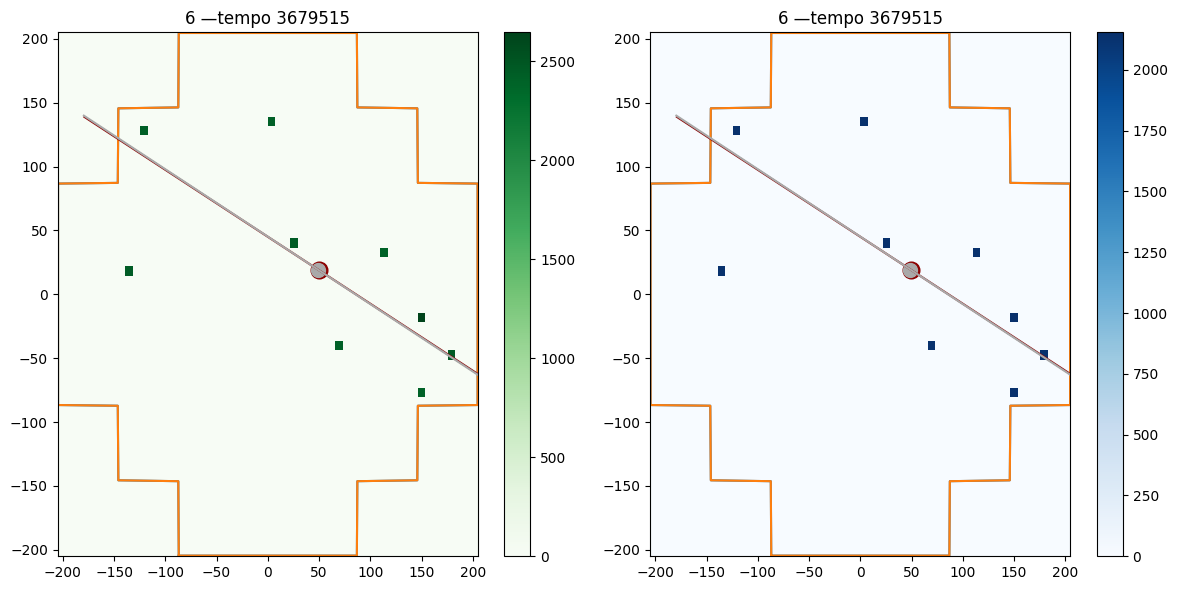

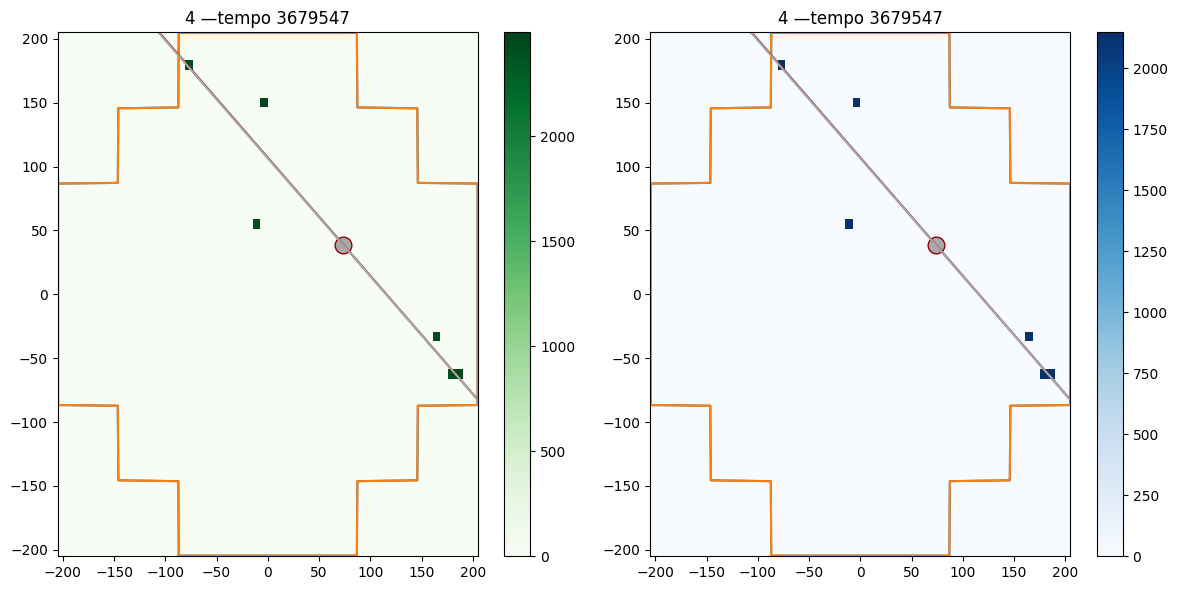

10
10
{'p0': array([-53.35482505,  13.80247121]), 'd': array([0.58880451, 0.80827548]), 'tel': 9}
18897


In [4]:
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

#fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(xfp, yfp, 'k-', linewidth=1)
rette_hg=[]
rette_lg=[]
for iv in range(10):
    itel=df_dt['TEL_ID'].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })
    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iv]} —tempo {df_all_sorted['TIME_ABS'][iv]}")
            ai.plot(xfp, yfp)
            #centroidi
            ai.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
            ai.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette_hg
            ai.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
            ai.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
    plt.show()
    

print(len(rette_hg))
print(len(rette_lg))
print(rette_hg[0])
print(len(df_dt))

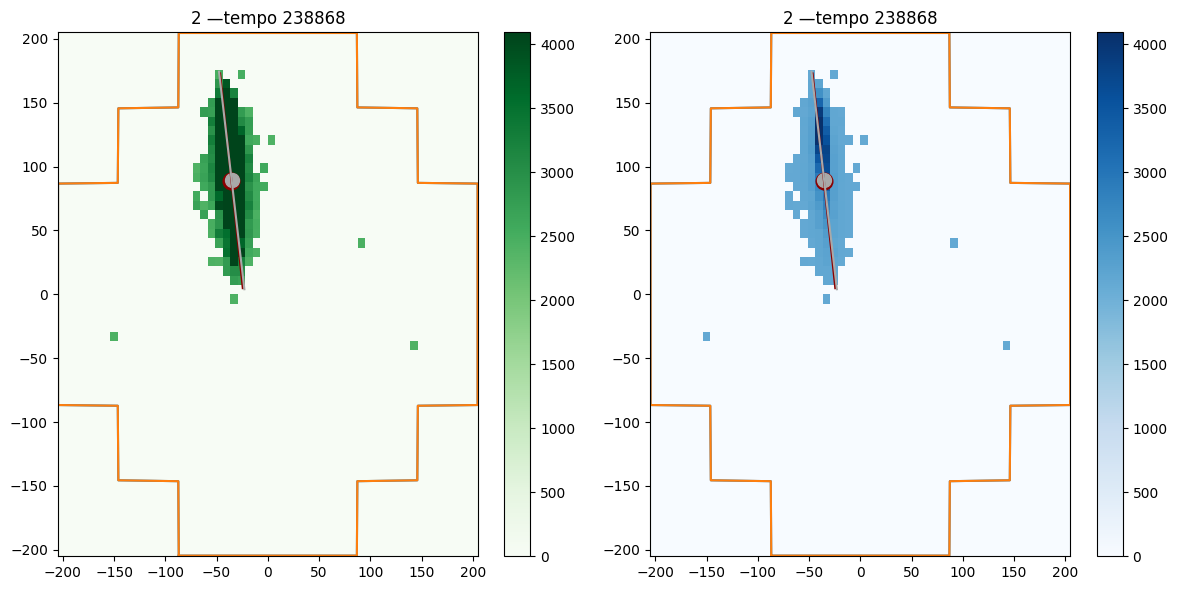

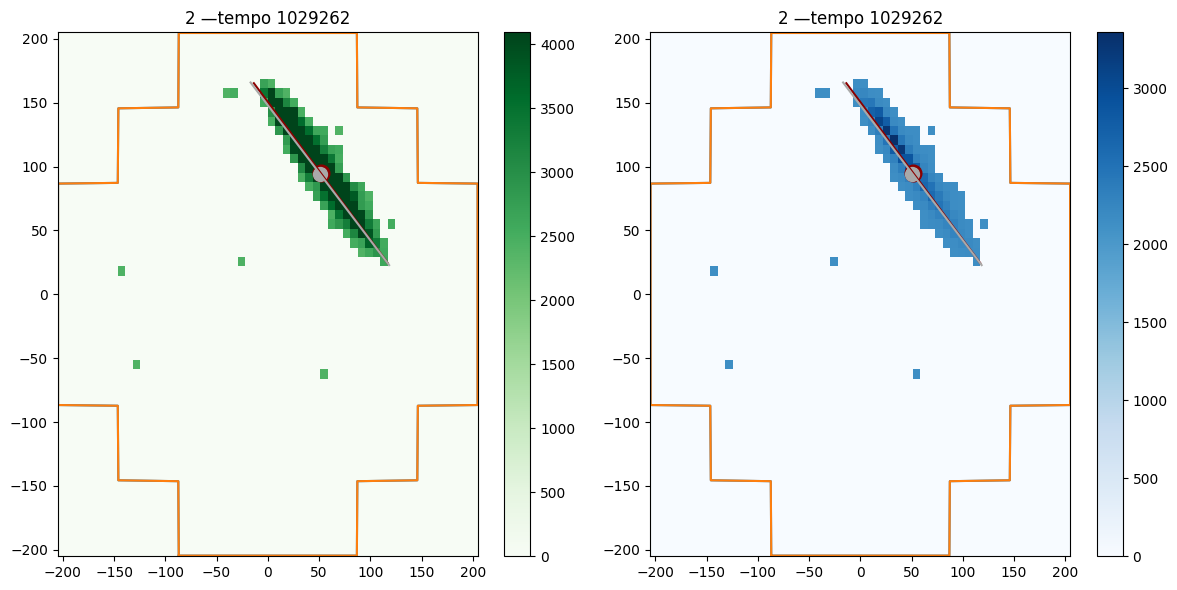

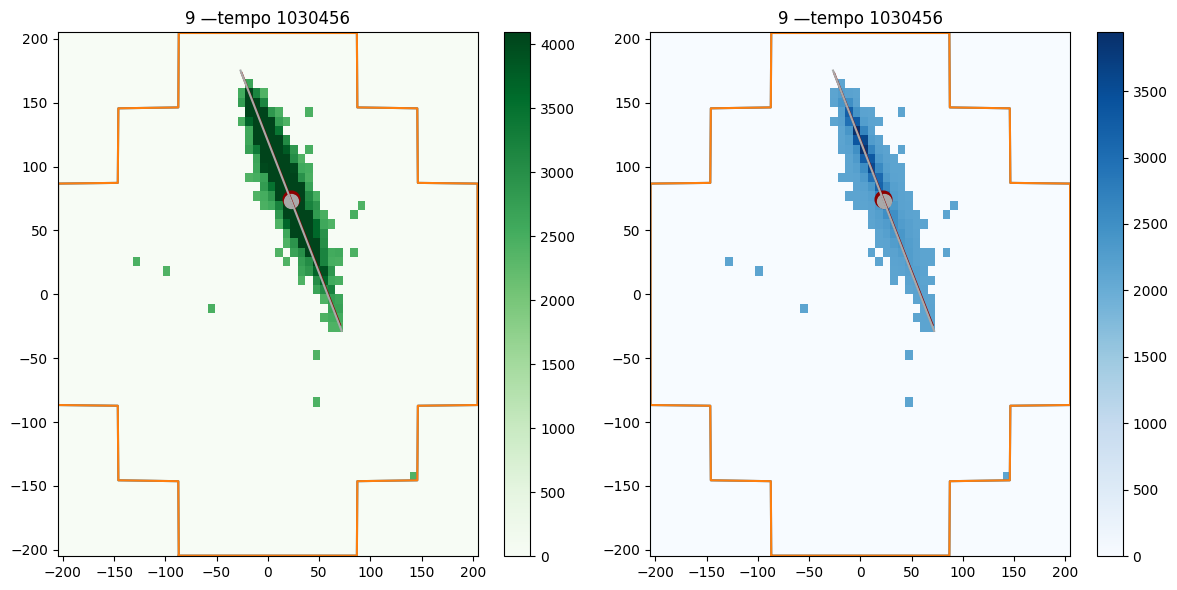

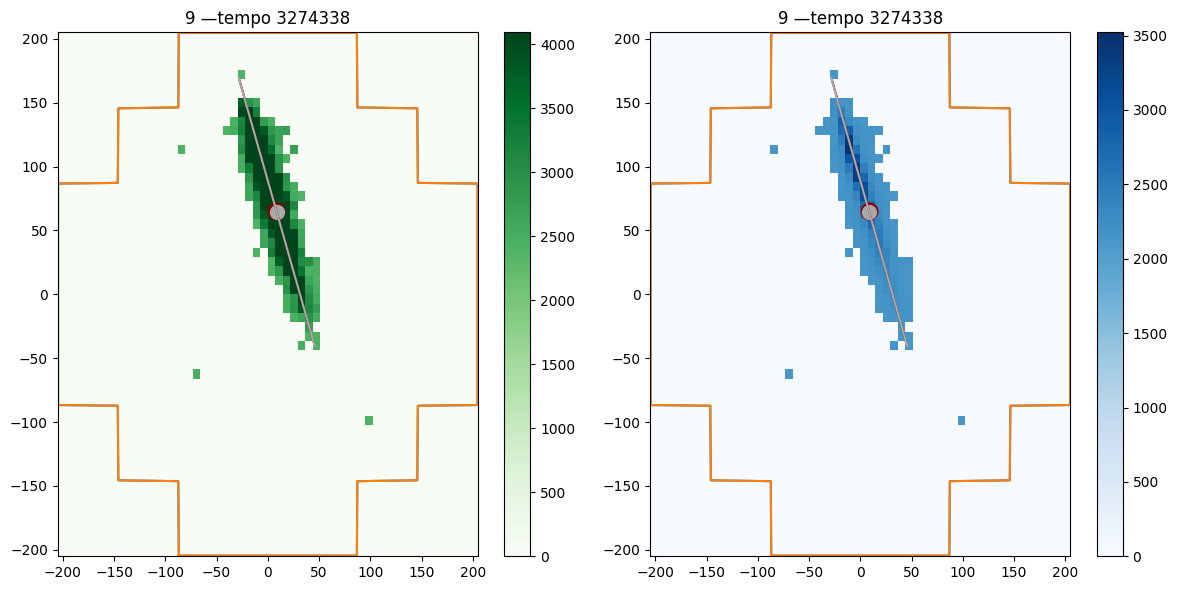

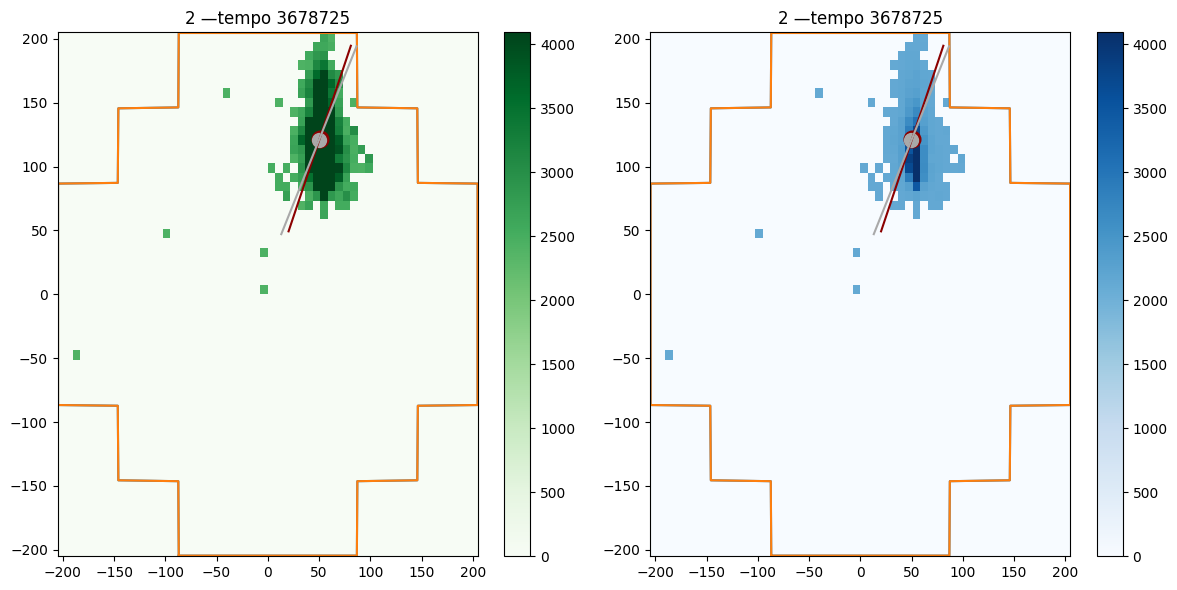

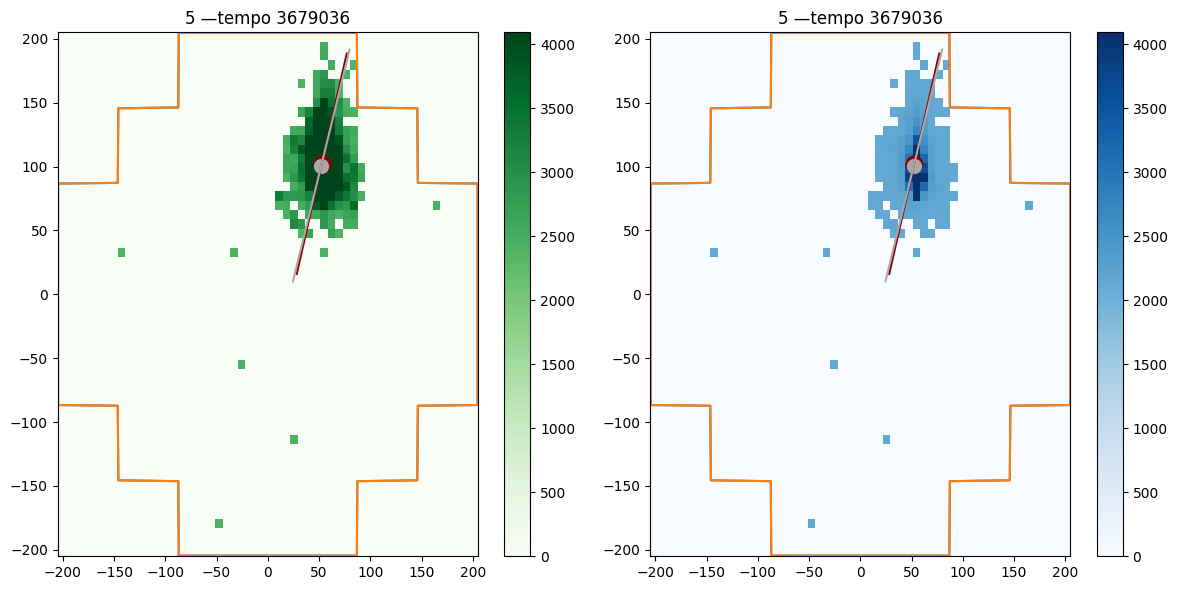

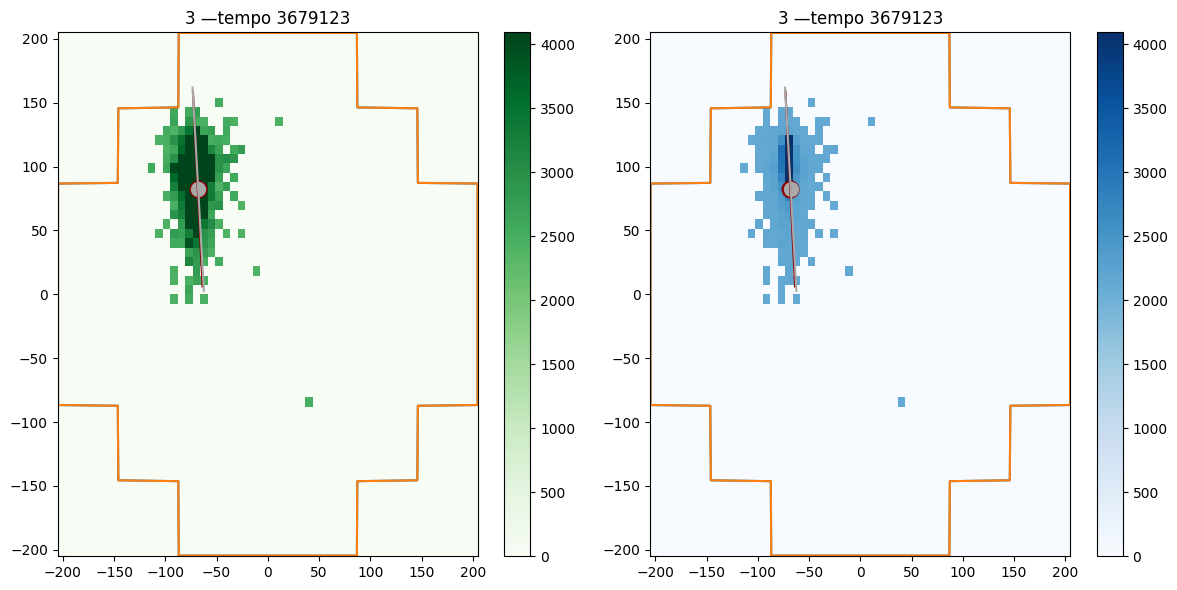

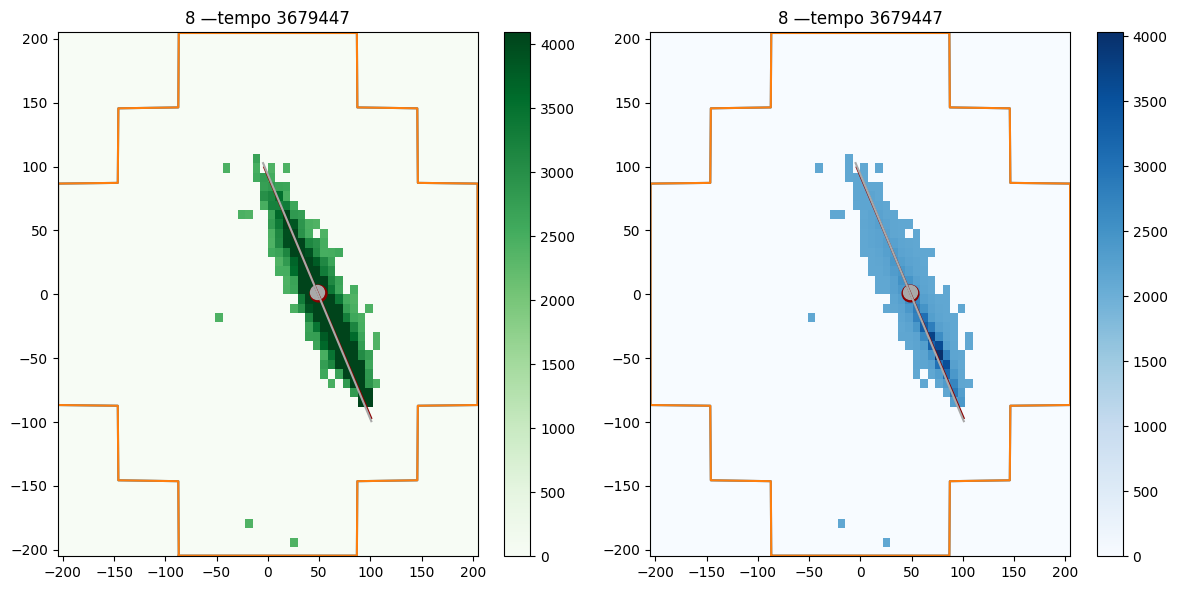

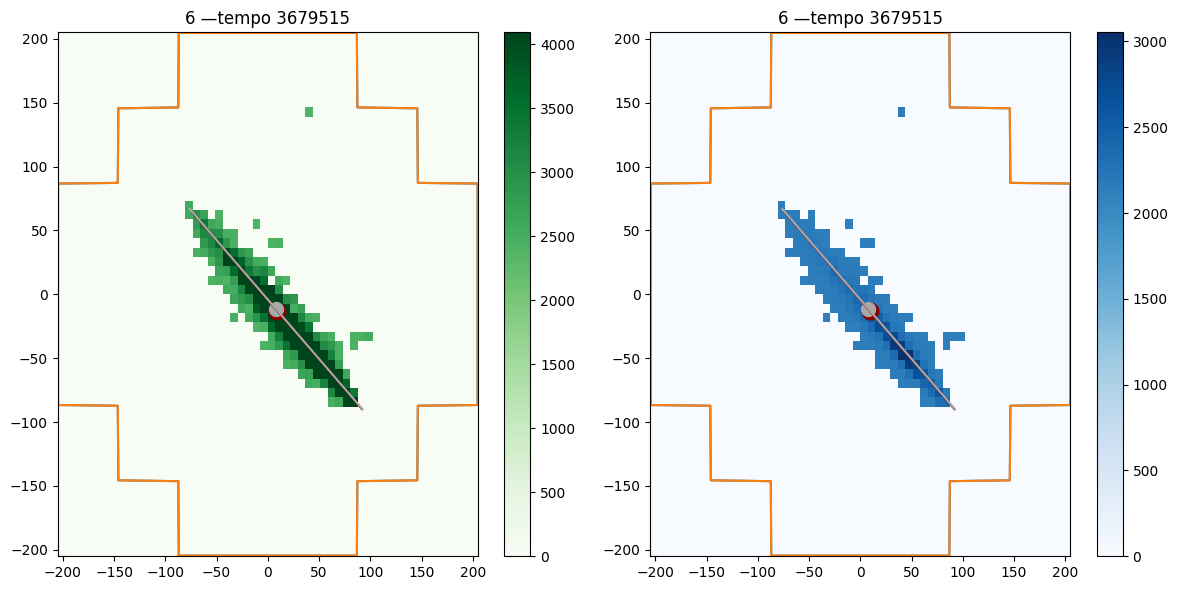

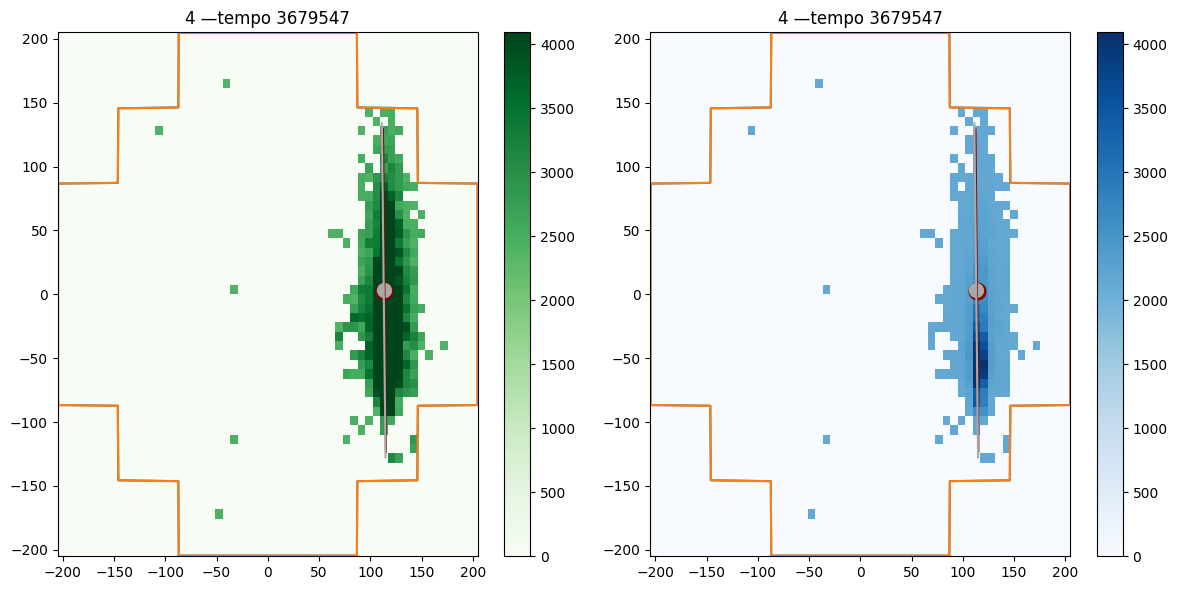

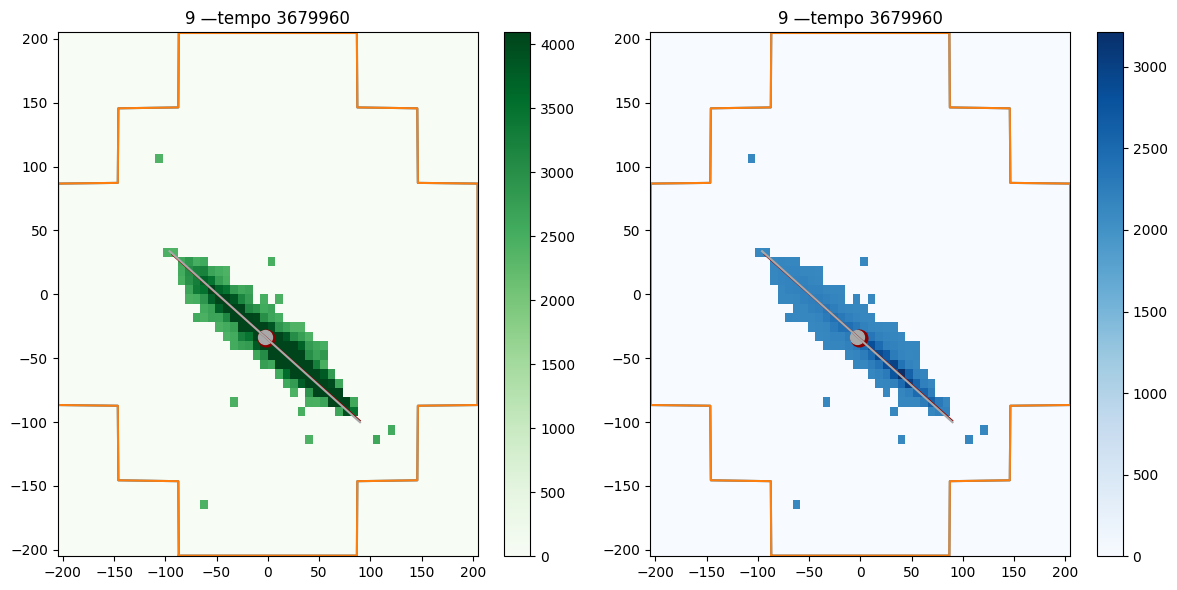

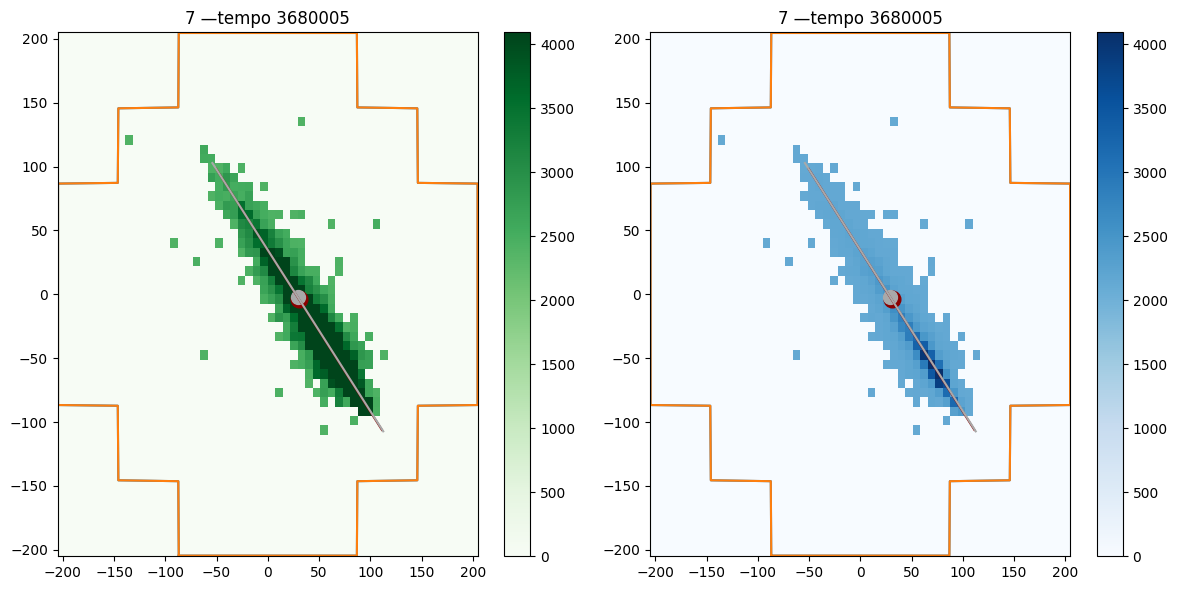

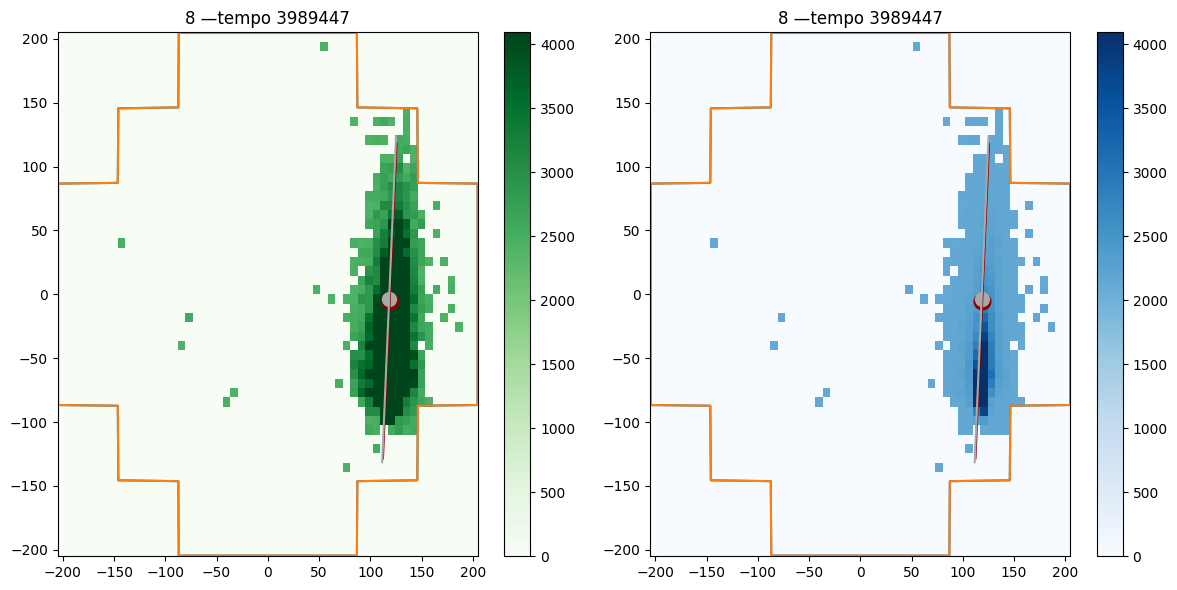

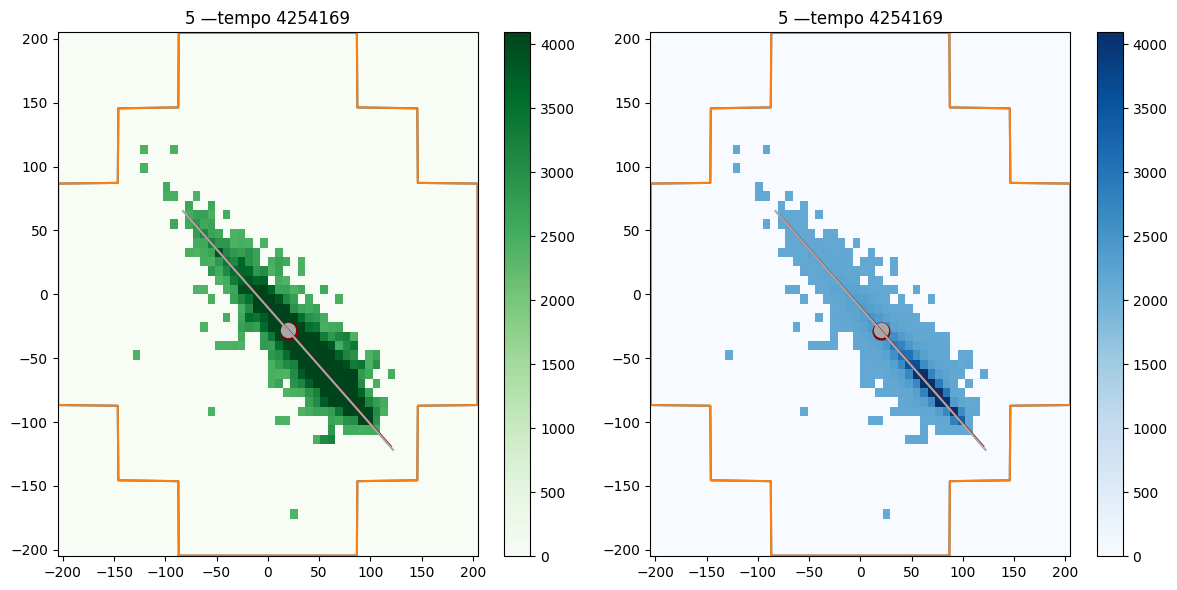

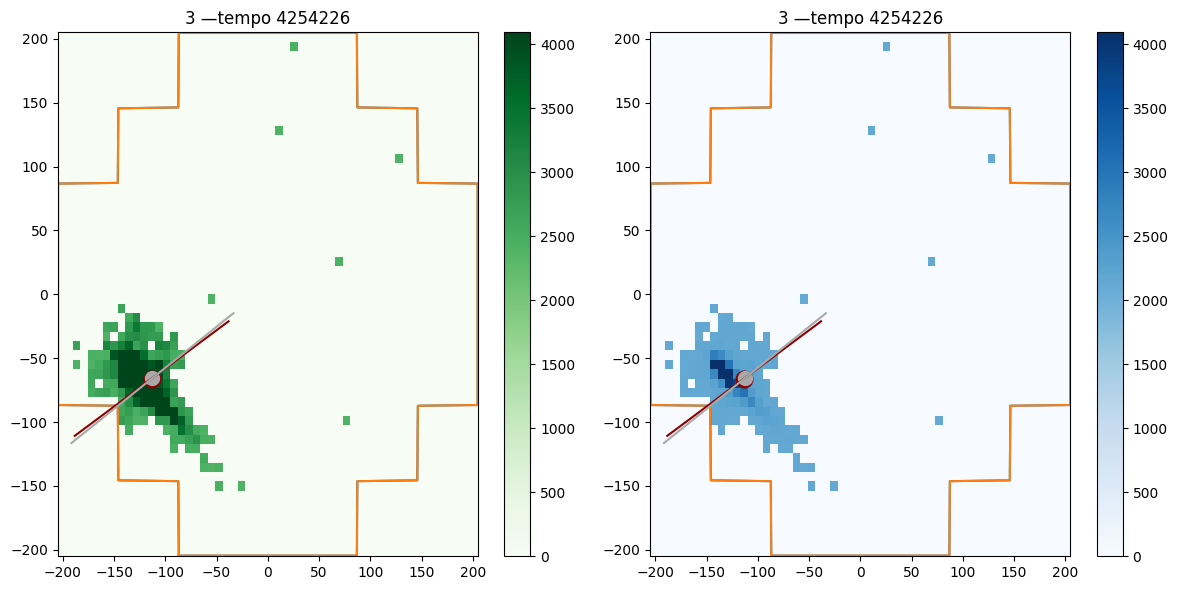

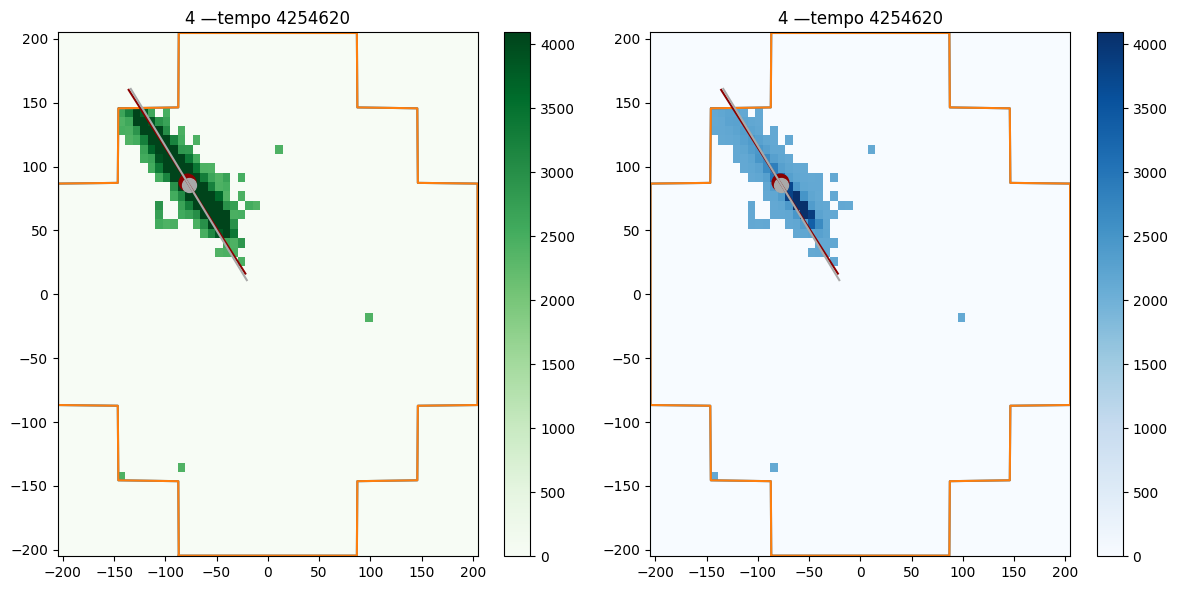

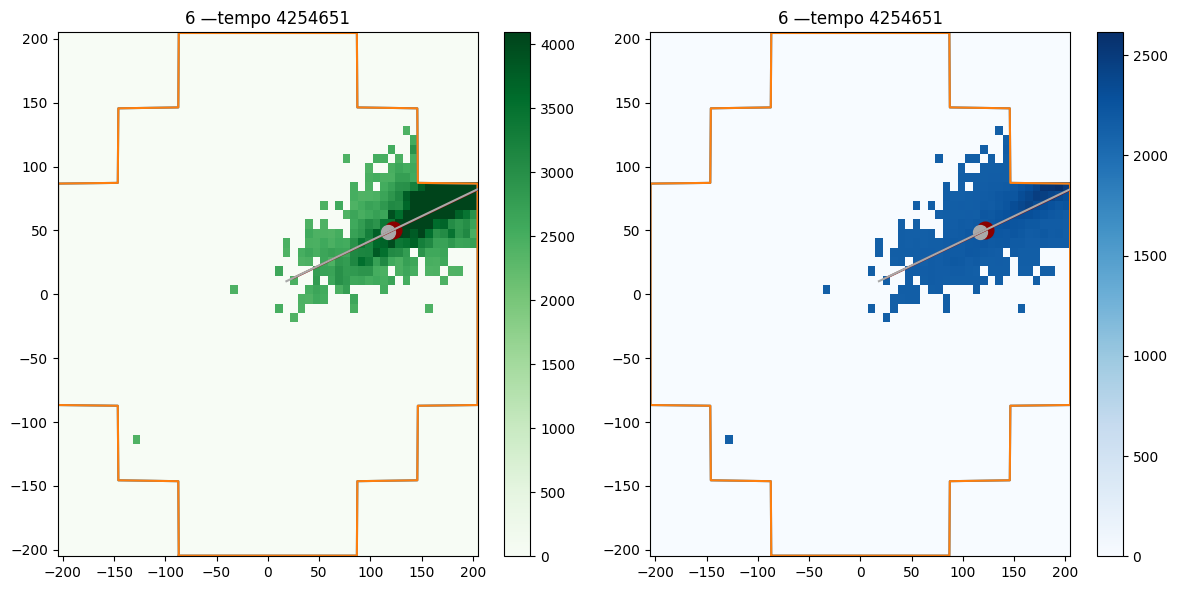

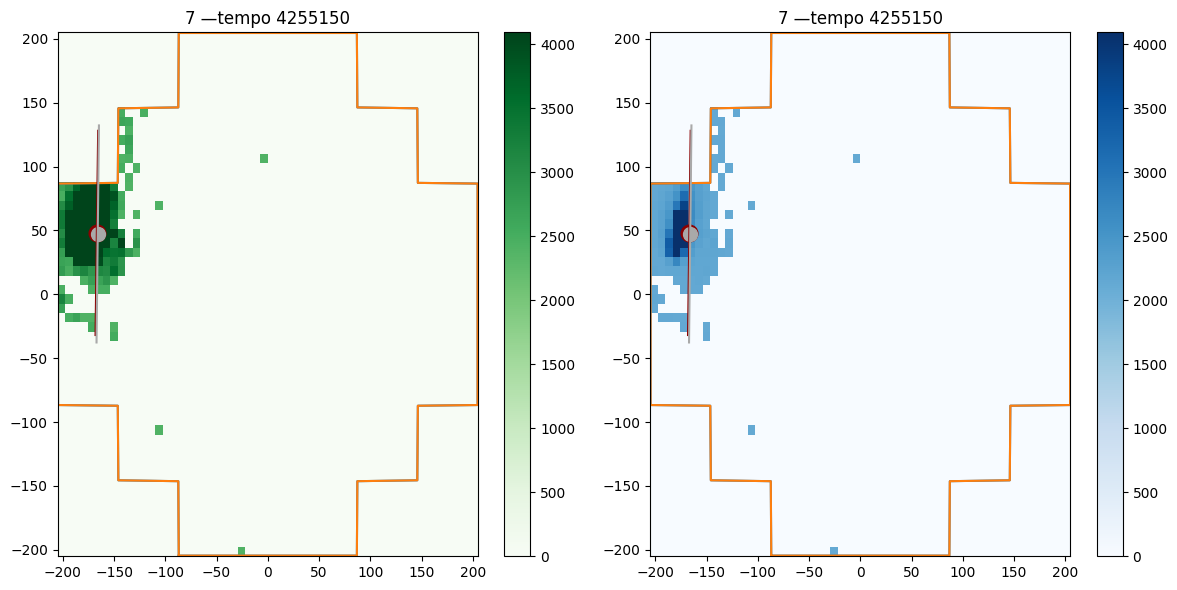

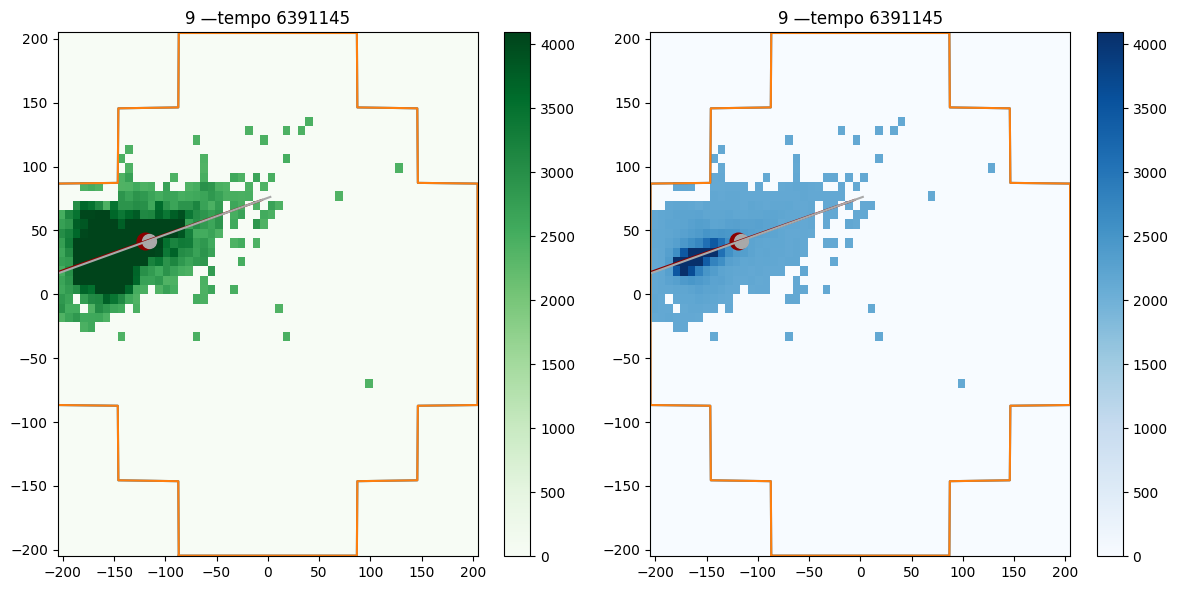

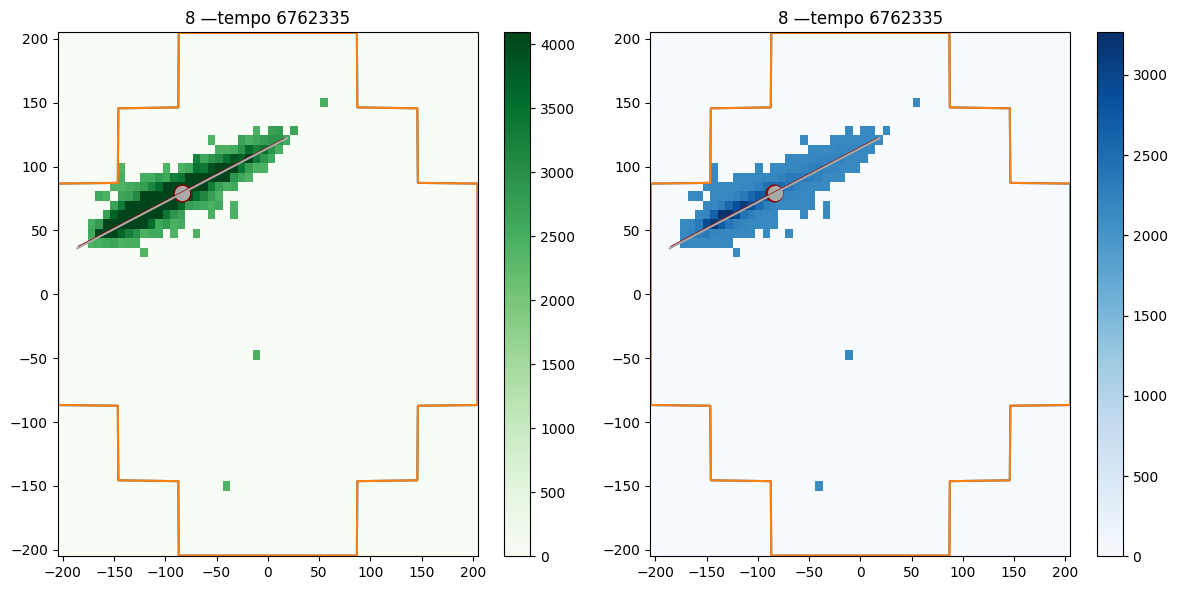

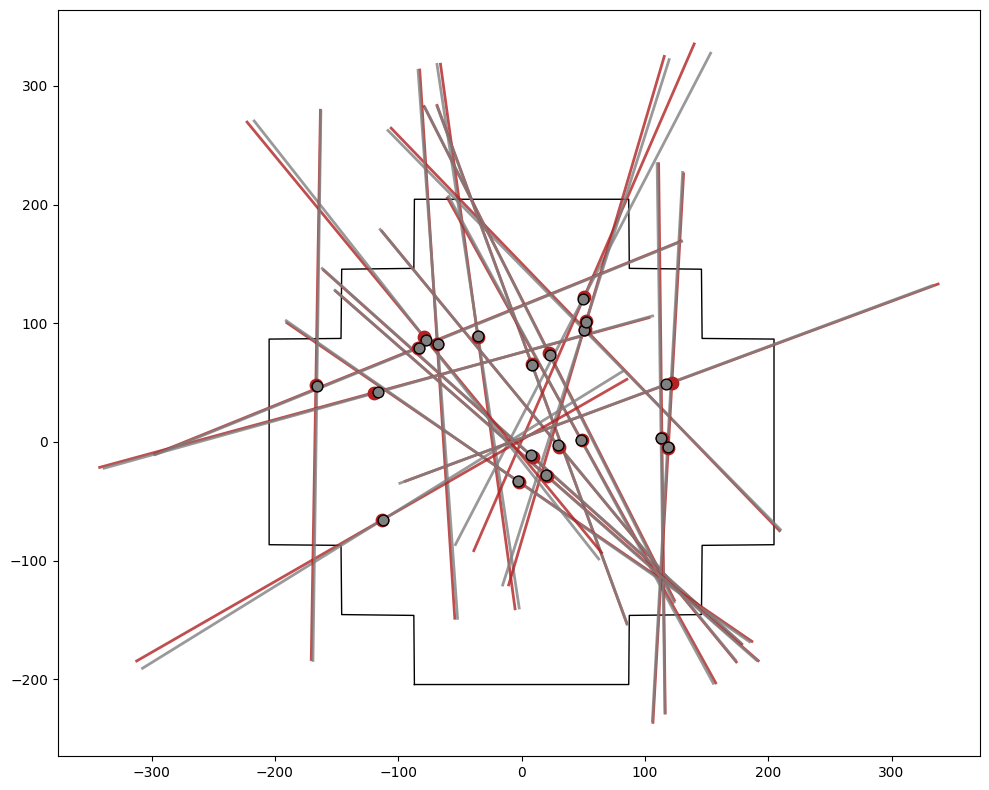

HG: 20
LG: 20
{'p0': array([-35.4986135 ,  88.81614181]), 'd': array([-0.13056647,  0.99143956]), 'tel': 1}
20
20
{'p0': array([-35.4986135 ,  88.81614181]), 'd': array([-0.13056647,  0.99143956]), 'tel': 1}
20


In [ ]:
df_dt = df_dt[df_dt["shape"] > 5280425 ]
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

#fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(xfp, yfp, 'k-', linewidth=1)
rette_hg=[]
rette_lg=[]
for iv in range(len(df_dt)):
    itel=df_dt['TEL_ID'].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]
    # filtro temporale
    pxmask =(hgev>2400) & (ttpev < 255)
    
    #centroidi
    meanx_hg = np.average(x_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(),weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(),weights=lgev[pxmask].flatten())
    #covarianze   
    cov_hg = np.cov([x_pix[pxmask].flatten(),y_pix[pxmask].flatten()],aweights=hgev[pxmask].flatten())            
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],aweights=lgev[pxmask].flatten())
            
    #print(cov_hg)
    stdx_hg,stdx_hg = np.sqrt(np.diagonal(cov_hg))
    stdx_lg,stdx_lg = np.sqrt(np.diagonal(cov_lg))

# Ellipsoid parameters from Covariance Matrix
    l1_hg=(cov_hg[0,0]+cov_hg[1,1])/2+np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    l2_hg= (cov_hg[0,0]+cov_hg[1,1])/2 -np.sqrt( ((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2 )
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg= (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    l2_lg= (cov_lg[0,0]+cov_lg[1,1])/2 - np.sqrt( ((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2 )
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })
    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)            
    hl = ax[0].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=hgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Greens')
    hh = ax[1].hist2d(x_pix[pxmask].flatten(),y_pix[pxmask].flatten(),
                          weights=lgev[pxmask].flatten(),range=((-205, 205), (-205, 205)),
                          bins=7*8, cmap='Blues')
    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])
    for ai in ax:
            ai.plot(xfp, yfp)
            ai.set_title(f"{df_all_sorted['TEL_ID'][iv]} —tempo {df_all_sorted['TIME_ABS'][iv]}")
            ai.plot(xfp, yfp)
            #centroidi
            ai.plot(meanx_hg, meany_hg, 'o',markersize=12, color='darkred')
            ai.plot(meanx_lg, meany_lg, 'o',markersize=10, color='darkgrey')
            #le rette_hg
            ai.plot( [meanx_hg-2*np.sqrt(l1_hg)*np.cos(theta_hg),
                      meanx_hg+2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                      [meany_hg-2*np.sqrt(l1_hg)*np.sin(theta_hg),meany_hg+
                       2*np.sqrt(l1_hg)*np.sin(theta_hg)],'-',color='darkred')
            ai.plot( [meanx_lg-2*np.sqrt(l1_lg)*np.cos(theta_lg),
                        meanx_lg+2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                        [meany_lg-2*np.sqrt(l1_lg)*np.sin(theta_lg),
                        meany_lg+2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                        '-', color='darkgrey')
    plt.show()
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xfp, yfp, 'k-', linewidth=1)

xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag

rette_hg = []
rette_lg = []

for iv in range(len(df_dt)):

    itel = df_dt["TEL_ID"].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]

    # mask di pixel buoni
    pxmask = (hgev > 2400) & (ttpev < 255)

    # ---------- centroidi ----------
    meanx_hg = np.average(x_pix[pxmask], weights=hgev[pxmask])
    meany_hg = np.average(y_pix[pxmask], weights=hgev[pxmask])

    meanx_lg = np.average(x_pix[pxmask], weights=lgev[pxmask])
    meany_lg = np.average(y_pix[pxmask], weights=lgev[pxmask])

    # ---------- covarianze ----------
    cov_hg = np.cov([x_pix[pxmask], y_pix[pxmask]], aweights=hgev[pxmask])
    cov_lg = np.cov([x_pix[pxmask], y_pix[pxmask]], aweights=lgev[pxmask])

    # ---------- direzione ellisse ----------
    l1_hg = (cov_hg[0,0] + cov_hg[1,1])/2 + np.sqrt(((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2)
    l1_lg = (cov_lg[0,0] + cov_lg[1,1])/2 + np.sqrt(((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2)

    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    # ---------- salva le rette per intersezioni ----------
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })

    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })

    
    # centroidi
    ax.scatter(meanx_hg, meany_hg, s=80, color="firebrick", zorder=5)
    ax.scatter(meanx_lg, meany_lg, s=60, color="grey", edgecolor="black", zorder=5)

    # rette lunghe stile codice 1
    x1 = meanx_hg - L*np.cos(theta_hg)
    y1 = meany_hg - L*np.sin(theta_hg)
    x2 = meanx_hg + L*np.cos(theta_hg)
    y2 = meany_hg + L*np.sin(theta_hg)
    ax.plot([x1, x2], [y1, y2], color='firebrick', linewidth=2, alpha=0.8)

    x1 = meanx_lg - L*np.cos(theta_lg)
    y1 = meany_lg - L*np.sin(theta_lg)
    x2 = meanx_lg + L*np.cos(theta_lg)
    y2 = meany_lg + L*np.sin(theta_lg)
    ax.plot([x1, x2], [y1, y2], color='grey', linewidth=2, alpha=0.8)




plt.tight_layout()
plt.show()

print("HG:", len(rette_hg))
print("LG:", len(rette_lg))
print(rette_hg[0])

print(len(rette_hg))
print(len(rette_lg))
print(rette_hg[0])
print(len(df_dt))

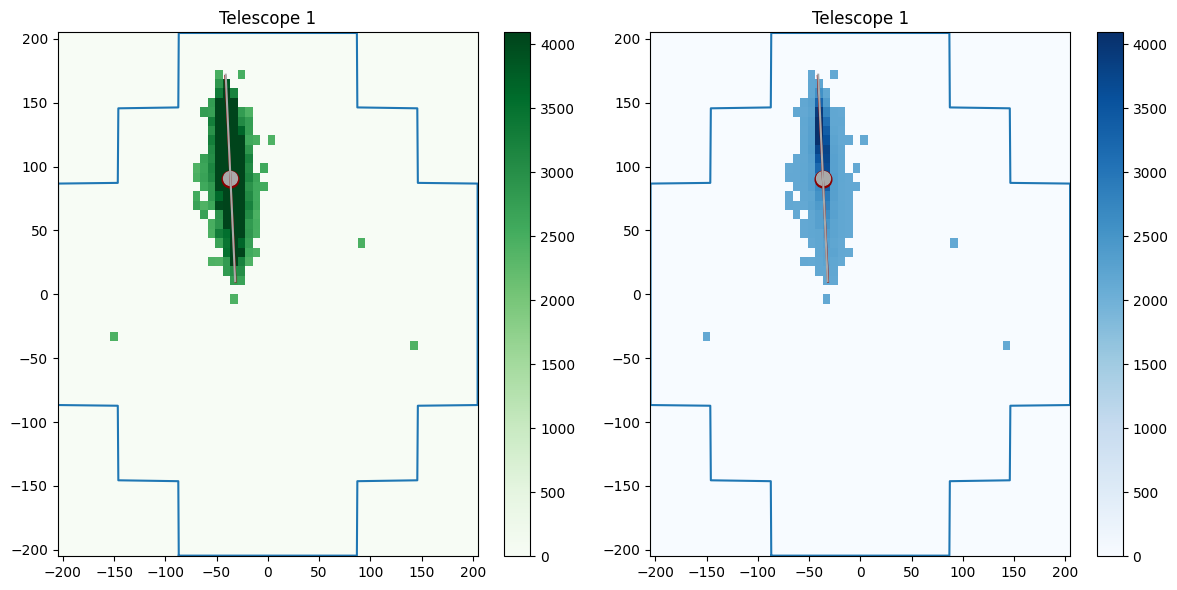

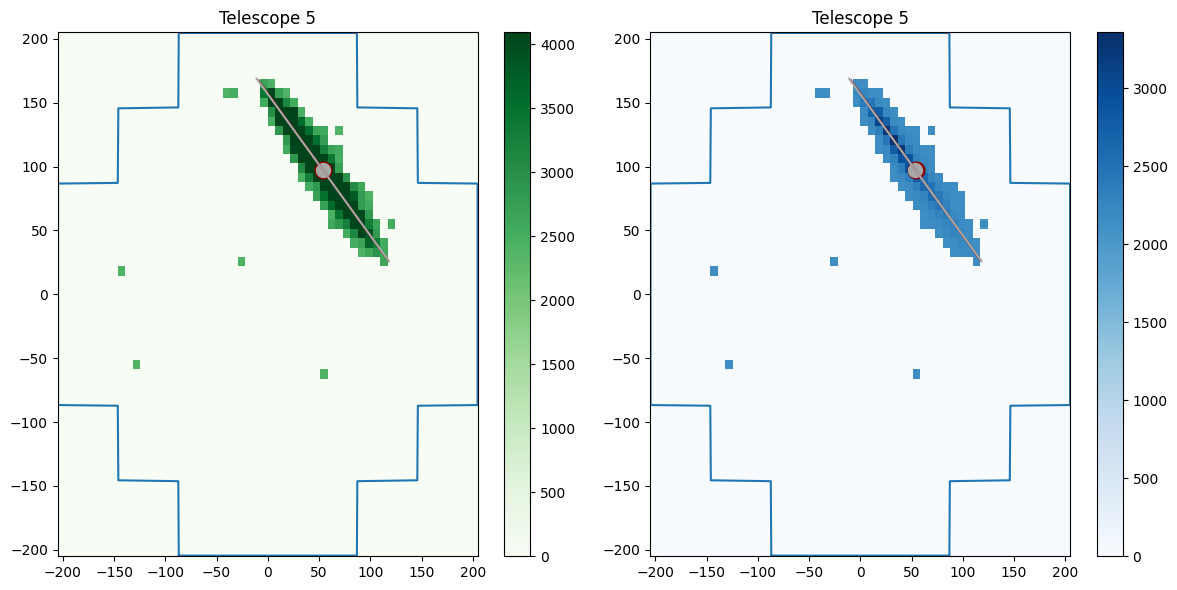

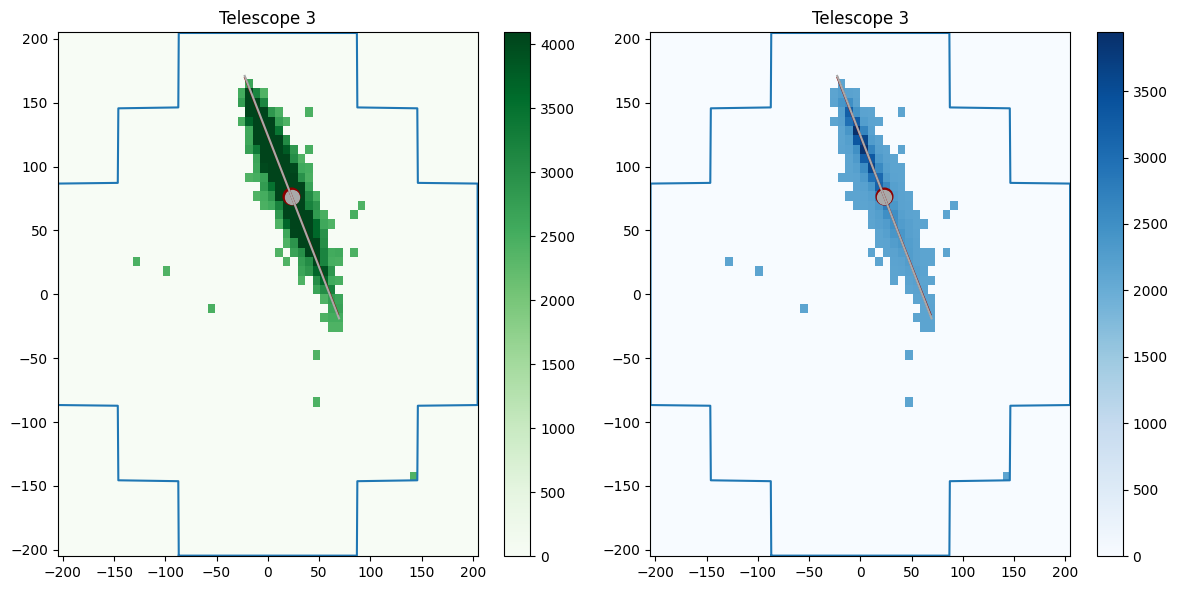

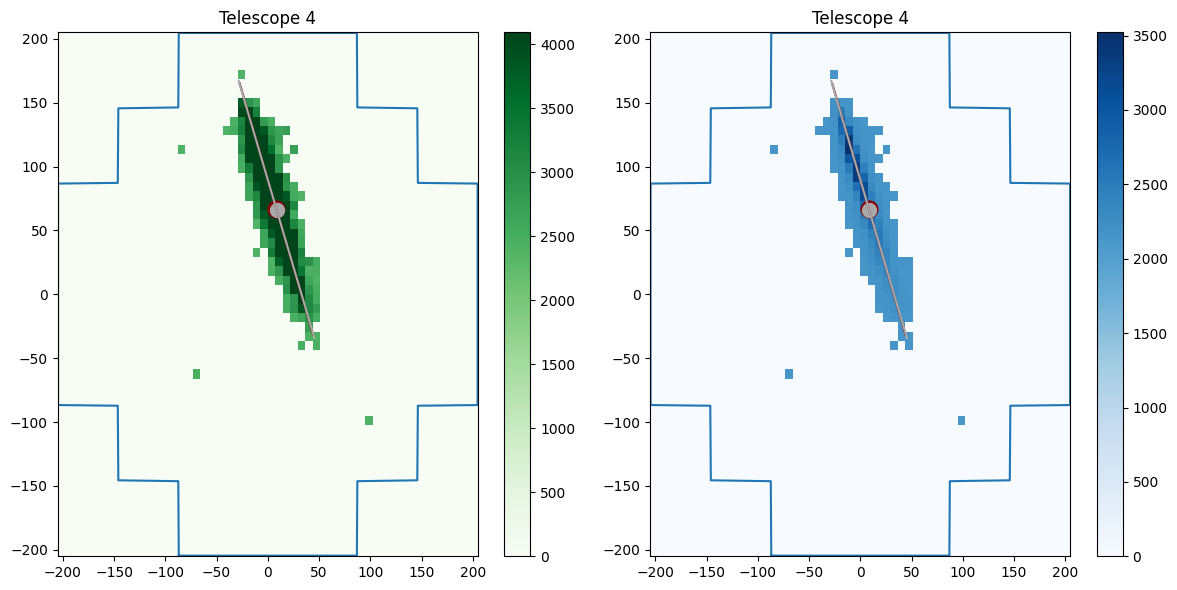

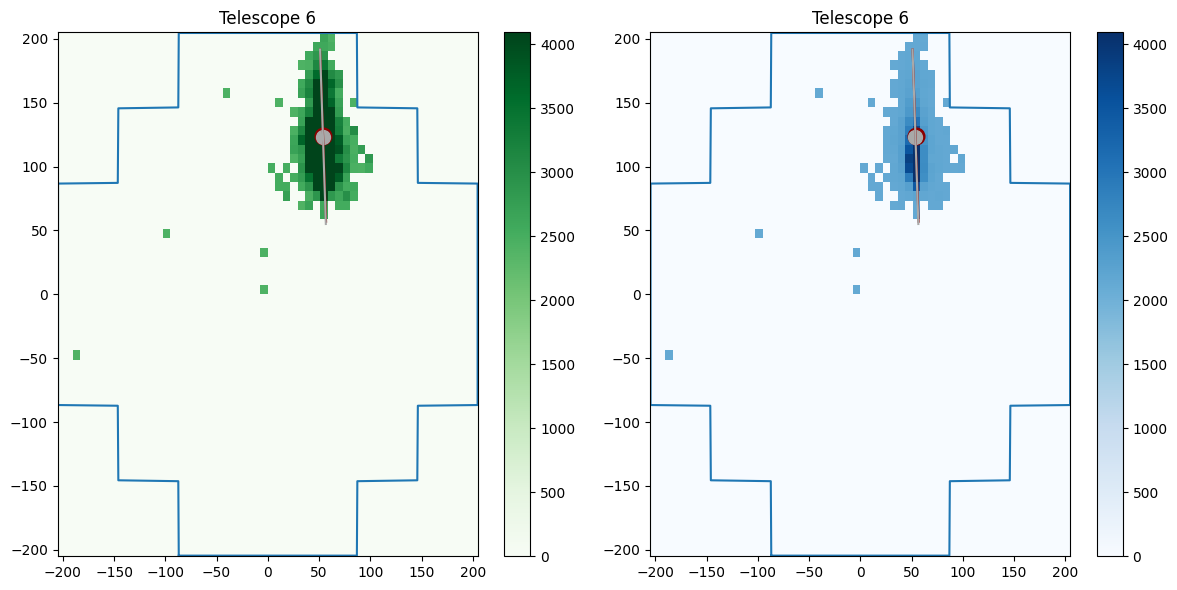

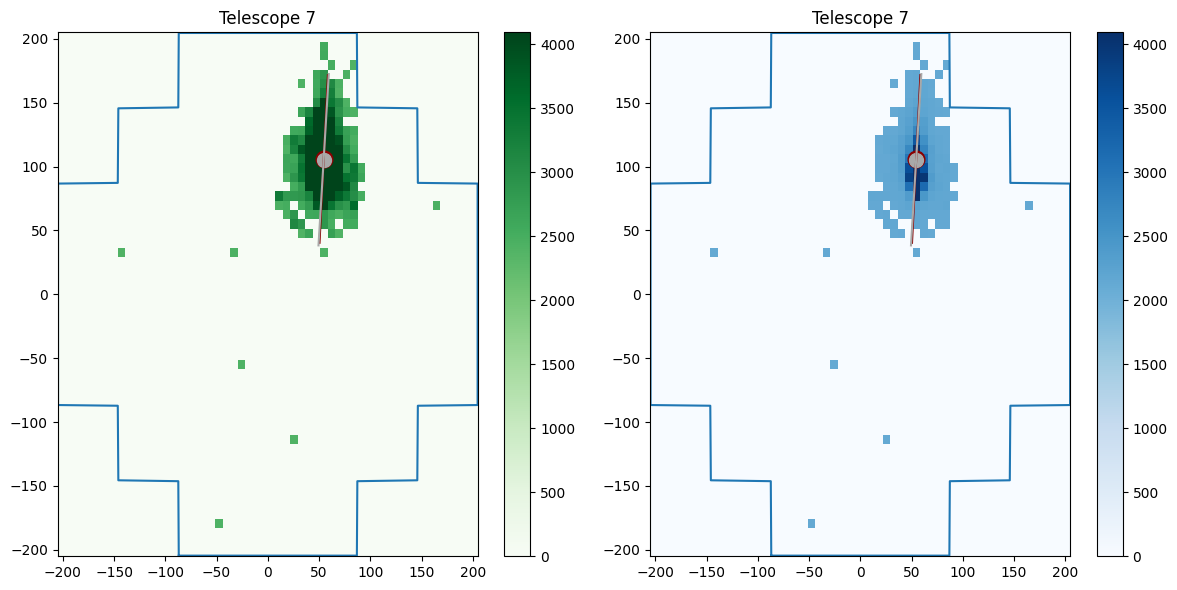

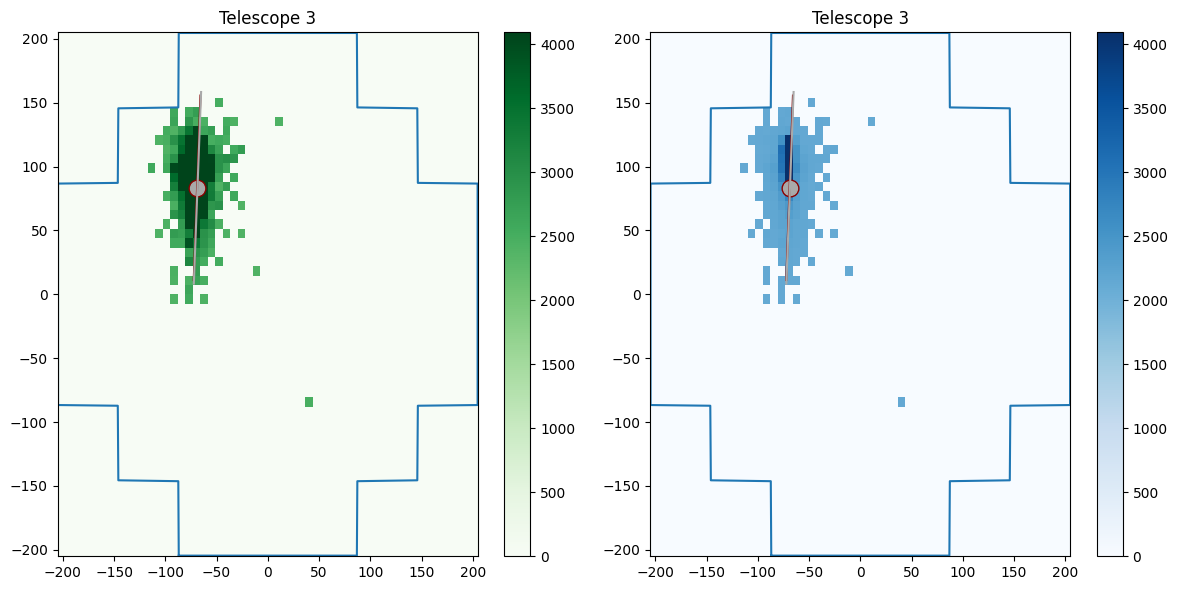

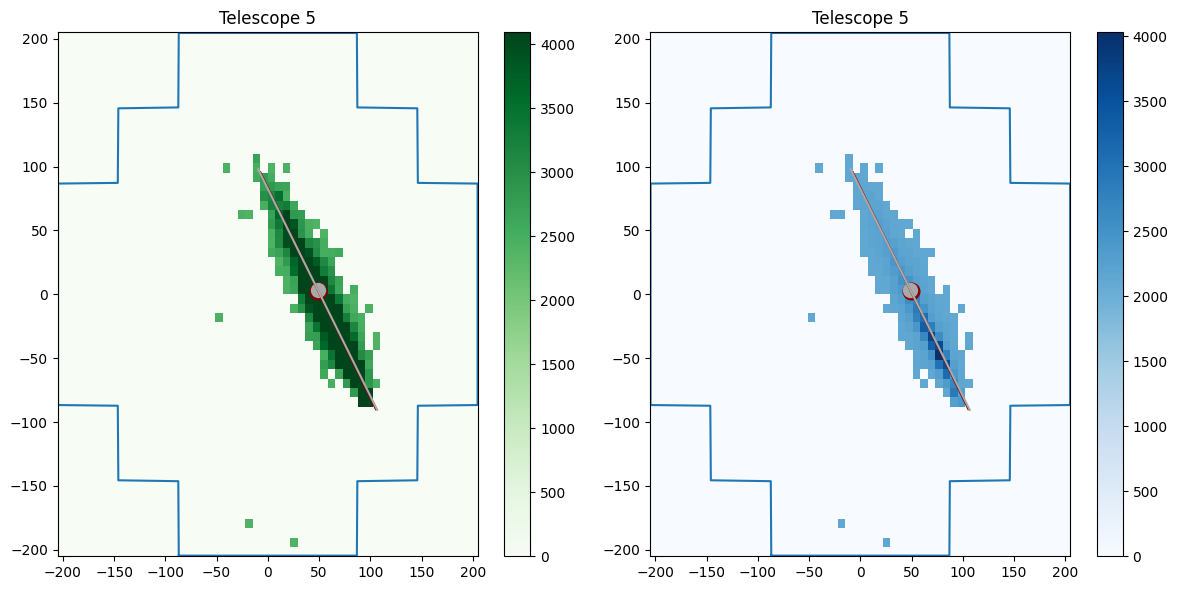

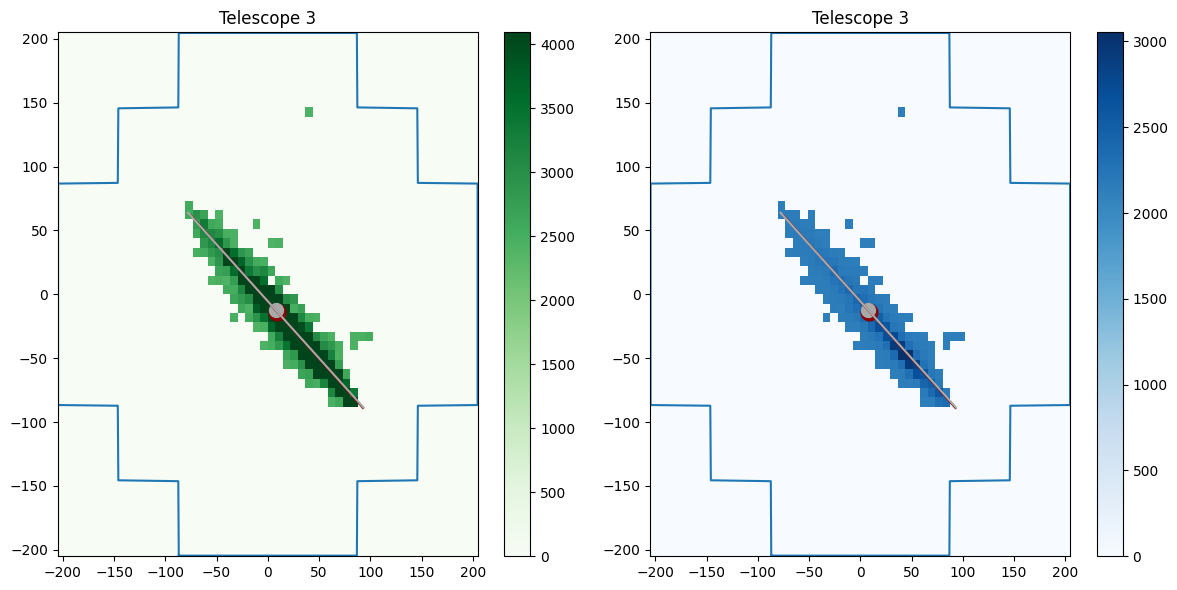

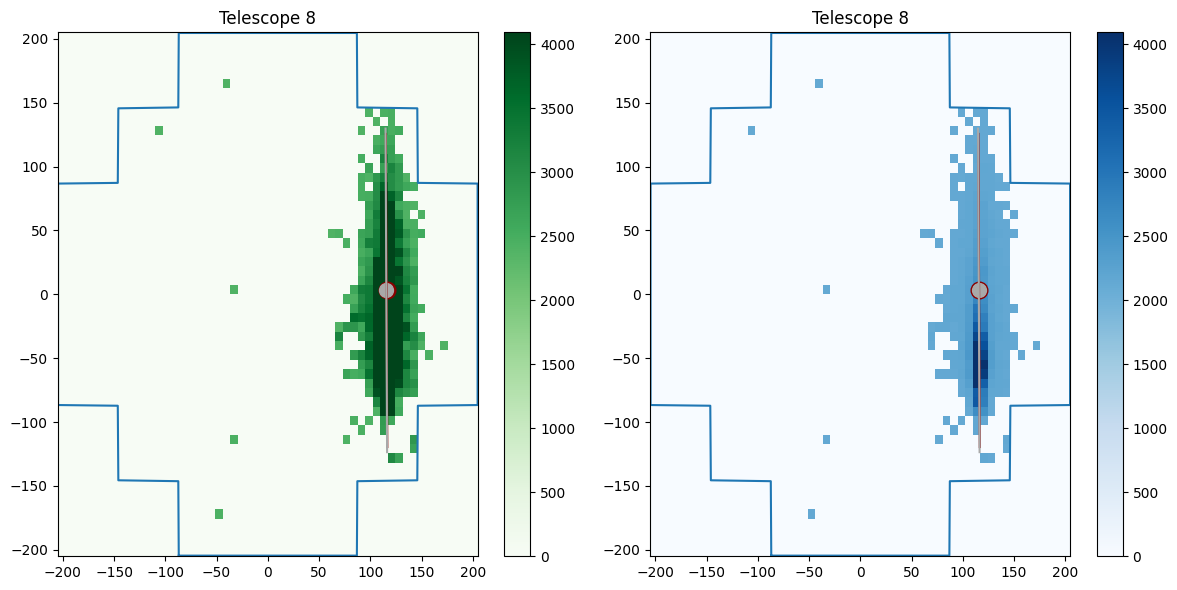

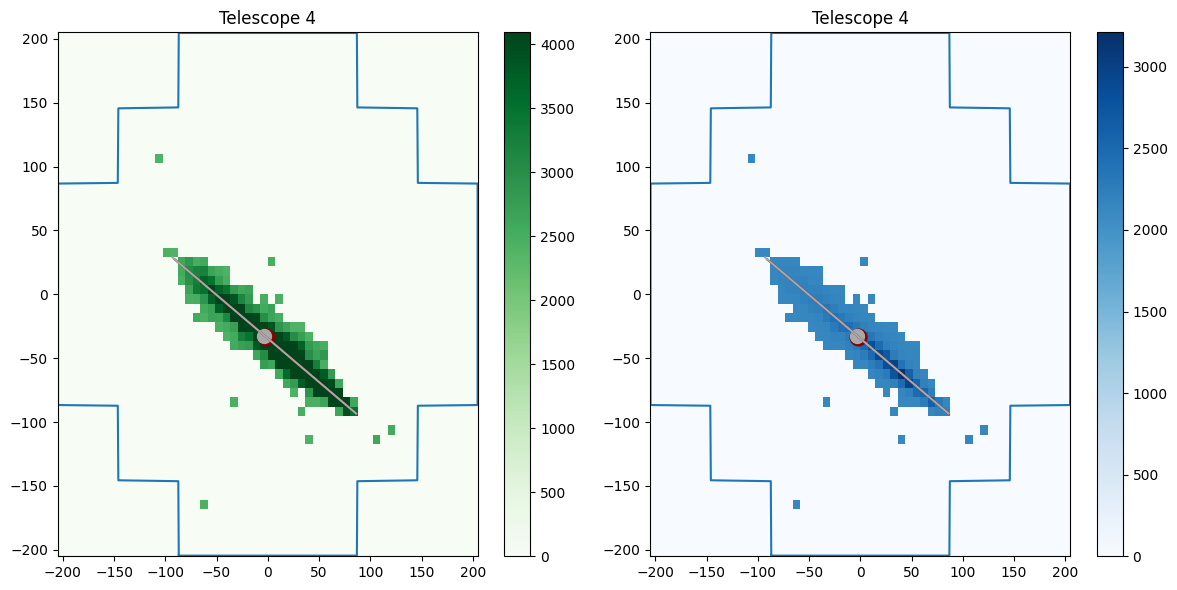

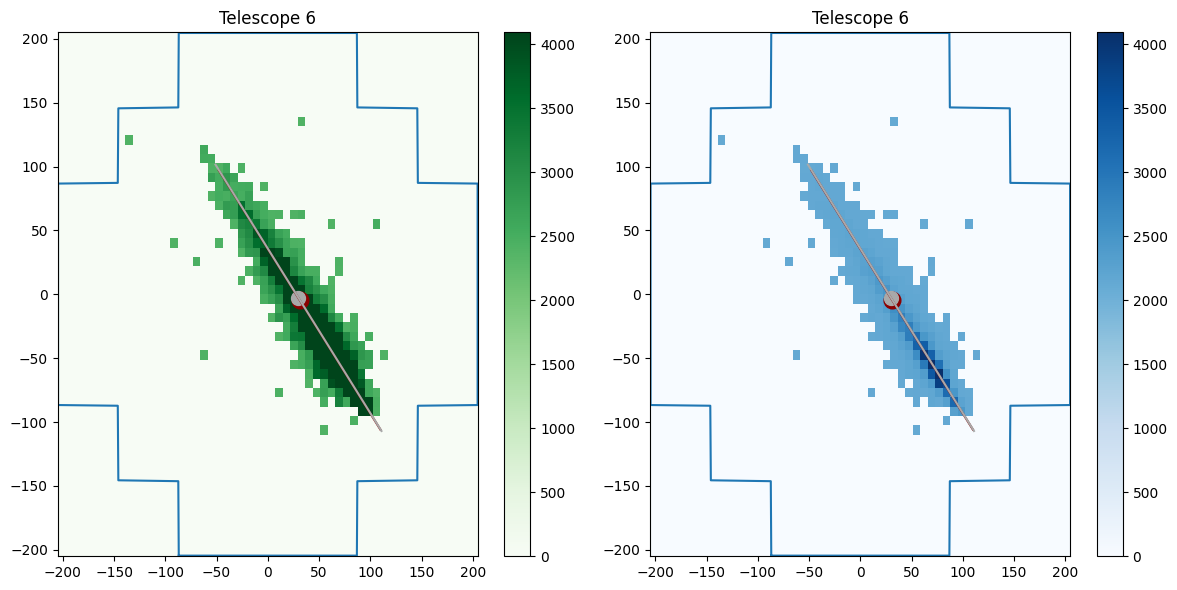

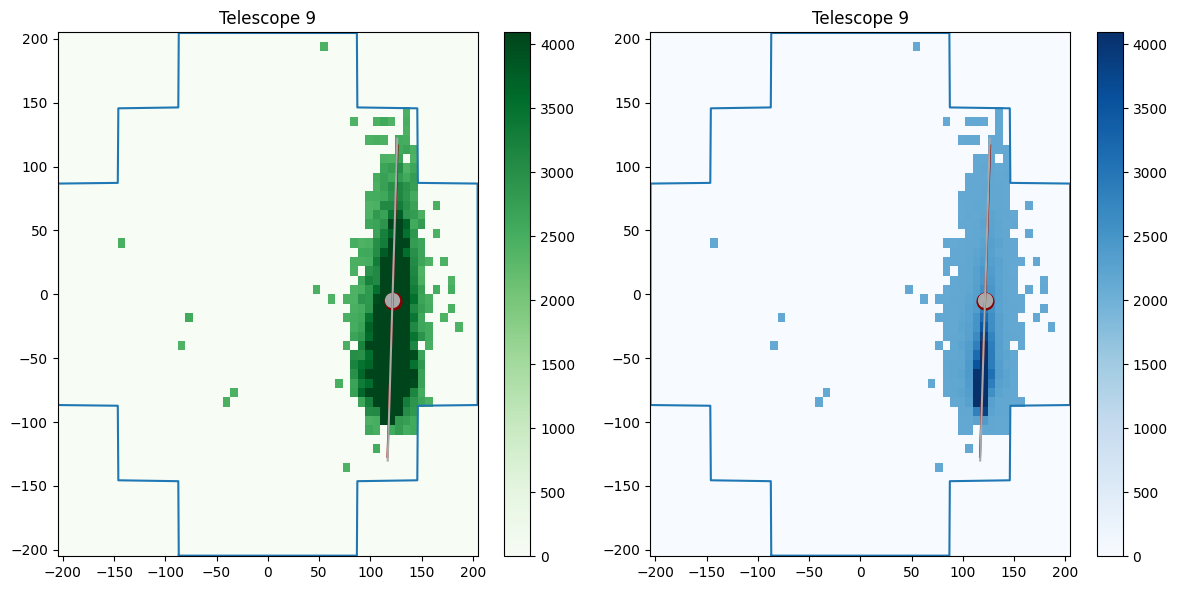

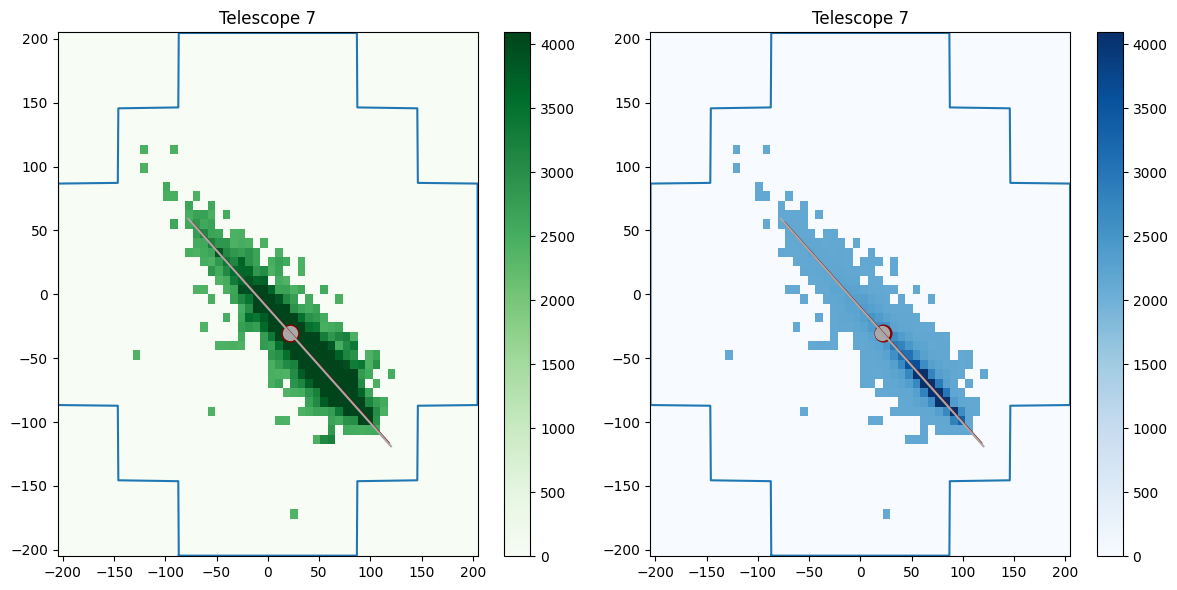

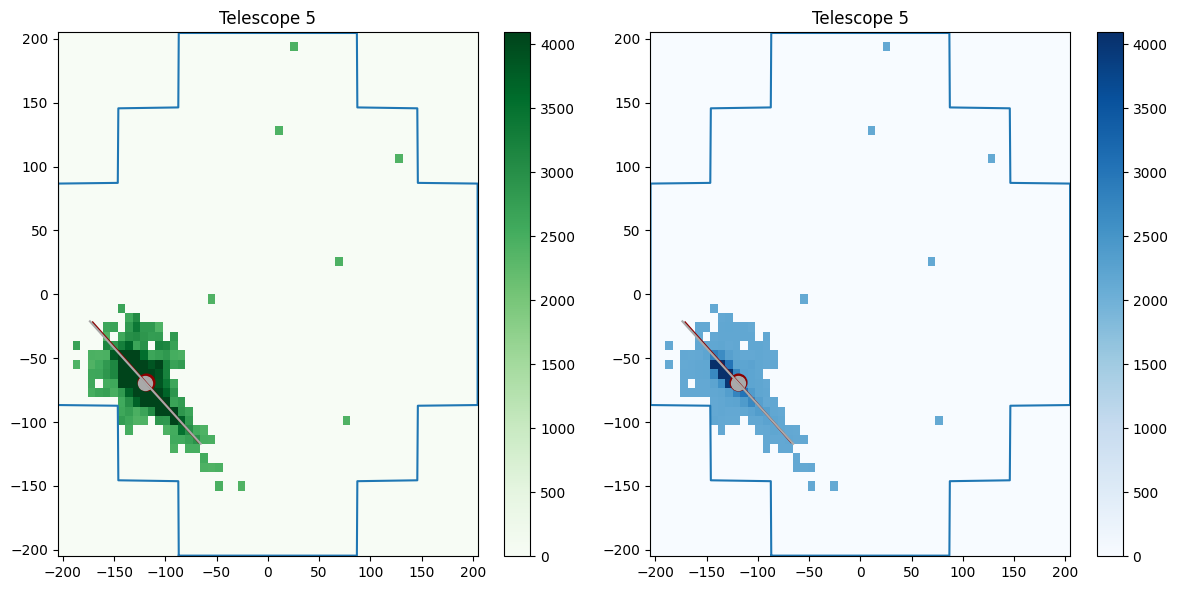

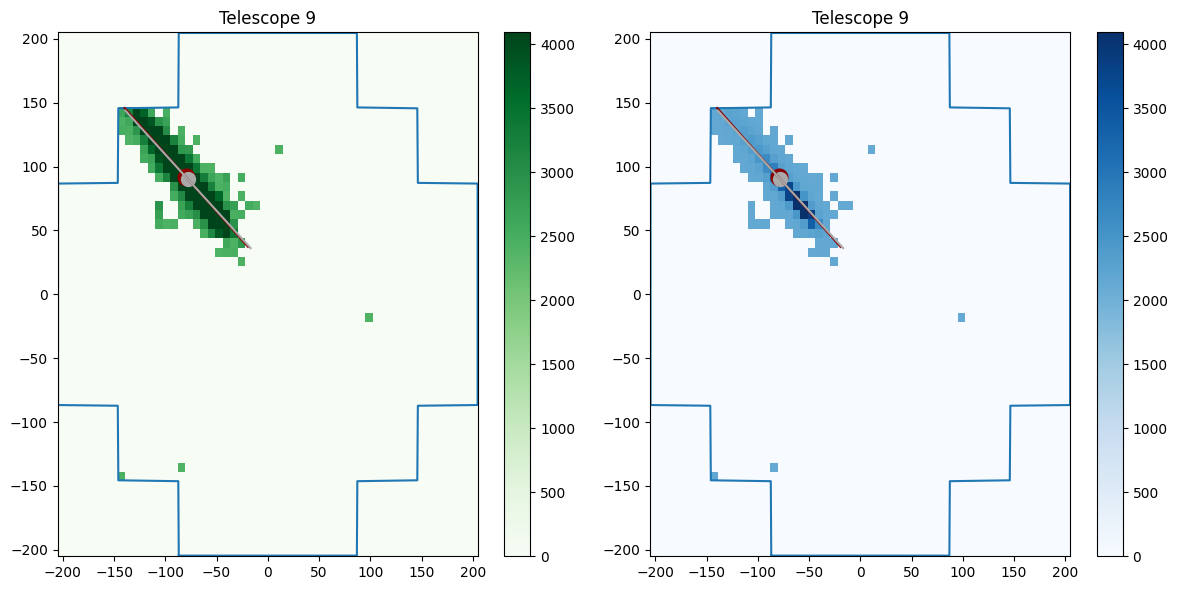

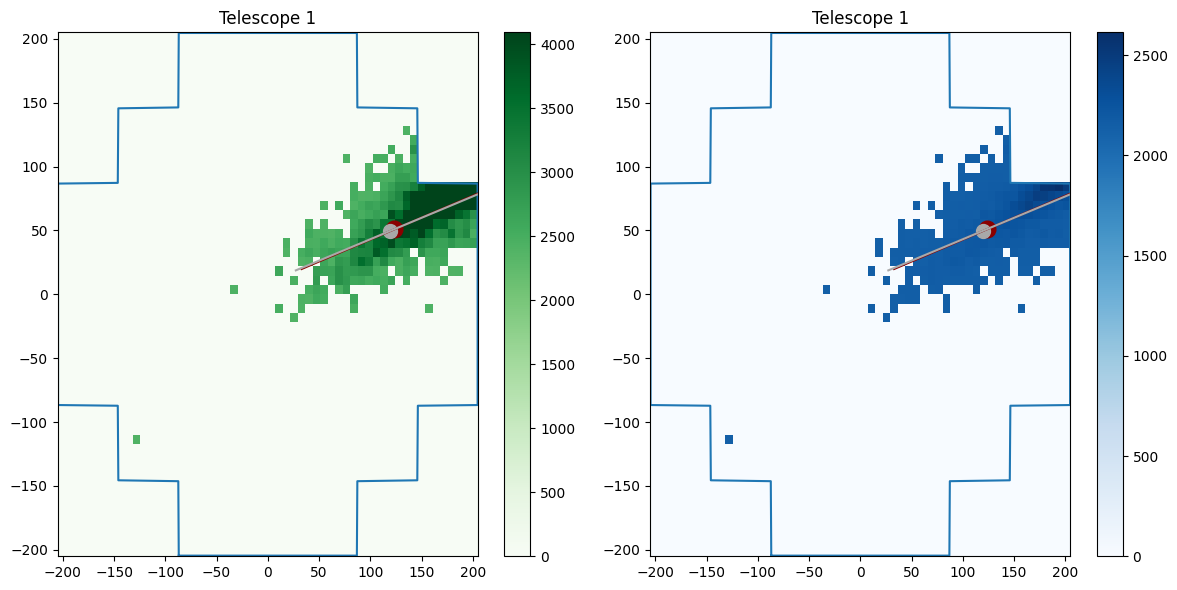

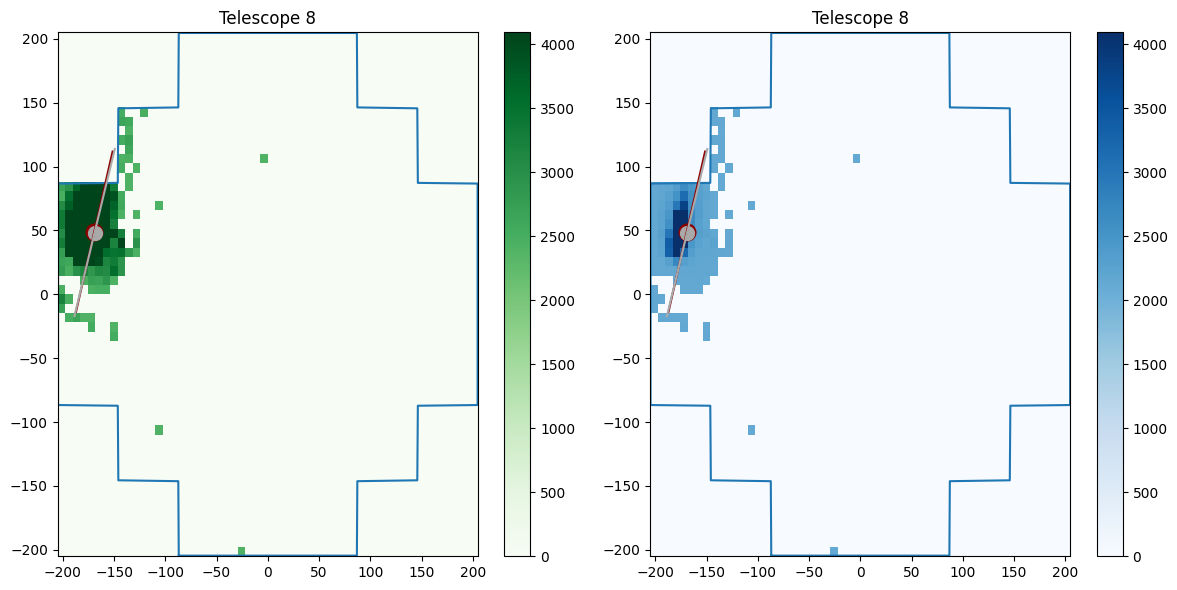

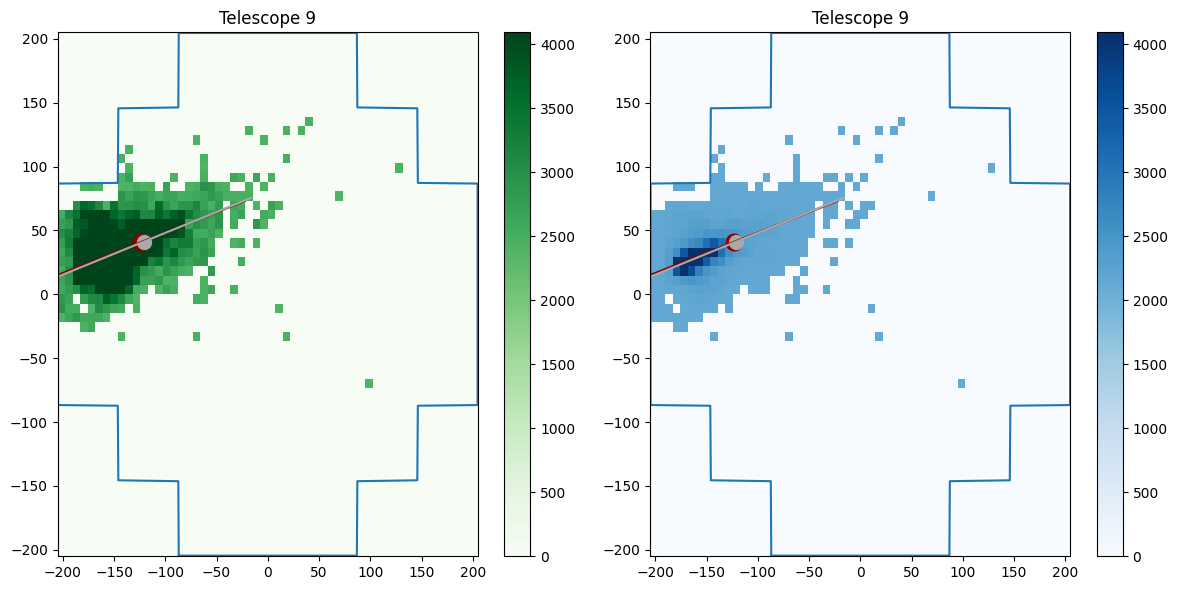

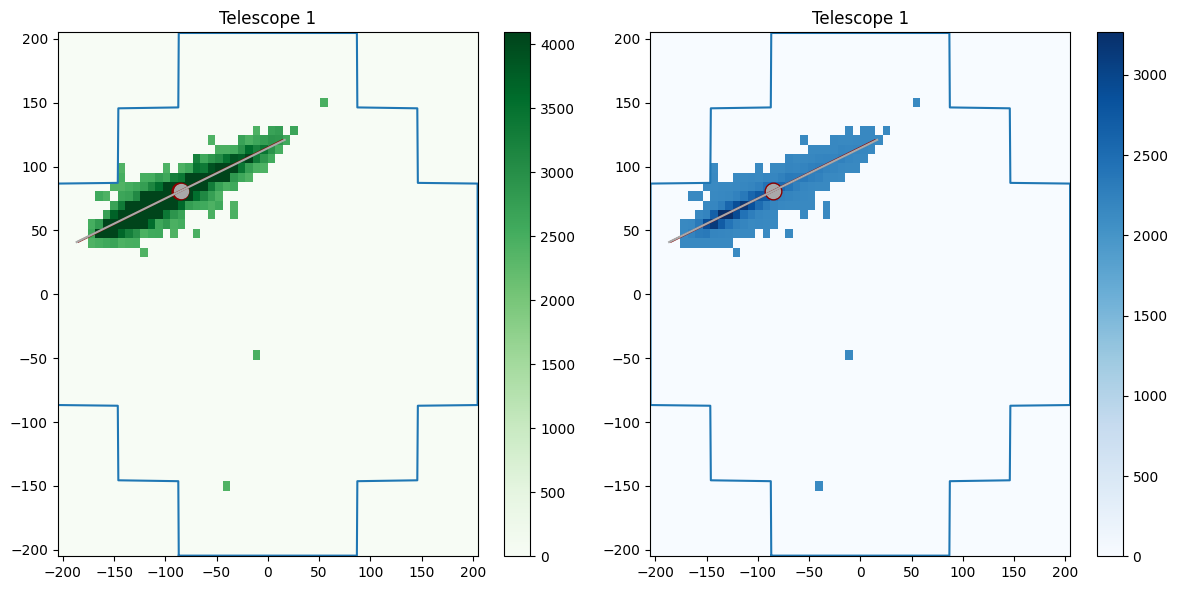

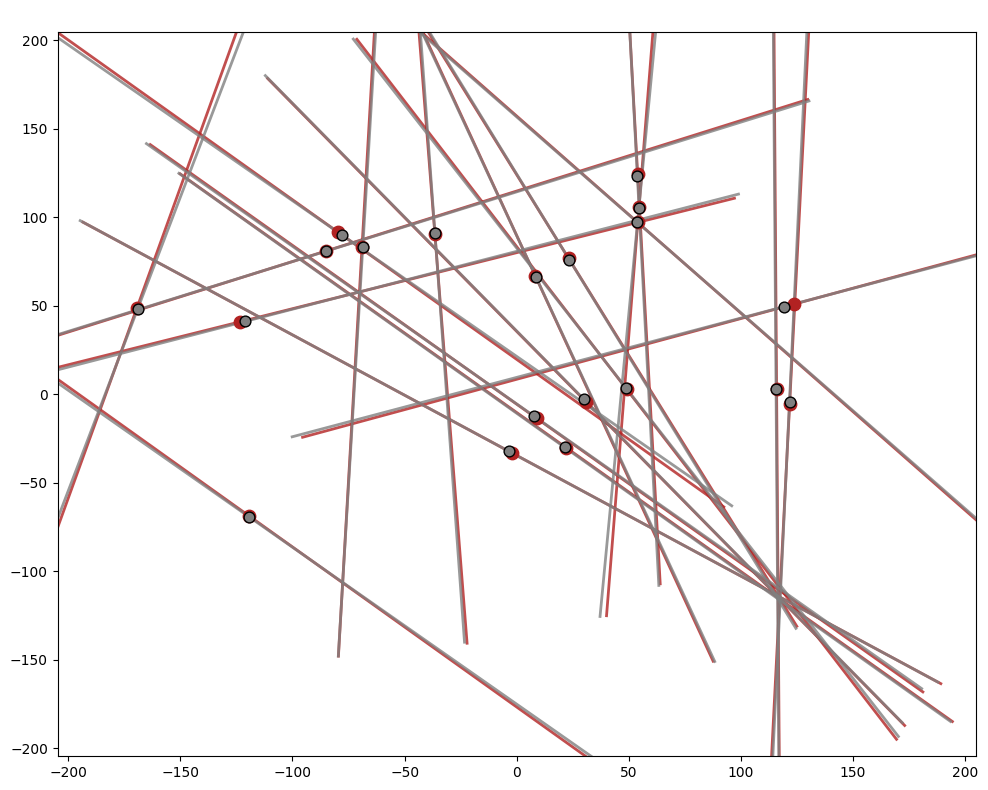

HG rette: 20
LG rette: 20
{'p0': array([-36.49597125,  90.39155262]), 'd': array([-0.06198727,  0.99807694]), 'tel': 1}


In [16]:
df_dt = df_dt[df_dt["shape"] > 5280425]

xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

rette_hg = []
rette_lg = []

# ============================================================
#   calcolo, sigma clip, istogrammi, salvataggio rette

for iv in range(len(df_dt)):

    itel = df_dt["TEL_ID"].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]

    # mask di pixel buoni
    pxmask = (hgev > 2400) & (ttpev < 255)

    # --------------------------
    # SIGMA-CLIPPING
    
    xx = x_pix[pxmask].flatten()
    yy = y_pix[pxmask].flatten()
    w_hg = hgev[pxmask].flatten()
    w_lg = lgev[pxmask].flatten()

    mx0 = np.average(xx, weights=w_hg)
    my0 = np.average(yy, weights=w_hg)

    r = np.sqrt((xx - mx0)**2 + (yy - my0)**2)

    r_clip, low, high = sc.sigmaclip(r, low=3.0, high=3.0)
    keep = (r >= low) & (r <= high)

    xx_sc = xx[keep]
    yy_sc = yy[keep]
    w_hg_sc = w_hg[keep]
    w_lg_sc = w_lg[keep]
    # --------------------------

    # ---------- centroidi ----------
    meanx_hg = np.average(xx_sc, weights=w_hg_sc)
    meany_hg = np.average(yy_sc, weights=w_hg_sc)

    meanx_lg = np.average(xx_sc, weights=w_lg_sc)
    meany_lg = np.average(yy_sc, weights=w_lg_sc)

    # ---------- covarianze ----------
    cov_hg = np.cov([xx_sc, yy_sc], aweights=w_hg_sc)
    cov_lg = np.cov([xx_sc, yy_sc], aweights=w_lg_sc)

    # ---------- direzione ellisse ----------
    l1_hg = (cov_hg[0,0] + cov_hg[1,1])/2 + np.sqrt(((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2)
    l1_lg = (cov_lg[0,0] + cov_lg[1,1])/2 + np.sqrt(((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2)

    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    # ---------- salvo le rette ----------
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })

    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })

    # ==========================================
    # 🔵 DUE ISTOGRAMMI — identici al tuo codice
    # ==========================================

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

    hl = ax[0].hist2d(xx, yy, weights=w_hg,
                      range=((-205, 205), (-205, 205)),
                      bins=7*8, cmap='Greens')

    hh = ax[1].hist2d(xx, yy, weights=w_lg,
                      range=((-205, 205), (-205, 205)),
                      bins=7*8, cmap='Blues')

    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])

    for ai in ax:
        ai.plot(xfp, yfp)
        ai.set_title(f"Telescope {itel}")
        ai.plot(meanx_hg, meany_hg, 'o', markersize=12, color='darkred')
        ai.plot(meanx_lg, meany_lg, 'o', markersize=10, color='darkgrey')

        # rette
        ai.plot([meanx_hg - 2*np.sqrt(l1_hg)*np.cos(theta_hg),
                 meanx_hg + 2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                [meany_hg - 2*np.sqrt(l1_hg)*np.sin(theta_hg),
                 meany_hg + 2*np.sqrt(l1_hg)*np.sin(theta_hg)],
                '-', color='darkred')

        ai.plot([meanx_lg - 2*np.sqrt(l1_lg)*np.cos(theta_lg),
                 meanx_lg + 2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                [meany_lg - 2*np.sqrt(l1_lg)*np.sin(theta_lg),
                 meany_lg + 2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                '-', color='darkgrey')

    plt.show()

# ============================================================
#   tutte le rette insieme (solo dai dati salvati)

fig, ax = plt.subplots(figsize=(10, 8))
# footprint camera in bianco
ax.plot(xfp, yfp, 'w-', linewidth=1)

# calcolo lunghezza estetica delle rette
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag

# disegno centroidi e rette HG (rosso/firebrick)
for r in rette_hg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide HG (punto rosso grande)
    ax.scatter(p0[0], p0[1], s=80, color="firebrick", zorder=5)

    # retta lunga HG (firebrick)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="firebrick", linewidth=2, alpha=0.8)

# disegno centroidi e rette LG (grigio)
for r in rette_lg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide LG (punto grigio più piccolo con bordo nero)
    ax.scatter(p0[0], p0[1], s=60, color="grey", edgecolor="black", zorder=5)

    # retta lunga LG (grey)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="grey", linewidth=2, alpha=0.8)

ax.set_title("Tutte le rette (HG firebrick, LG grey)", color="white")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

print("HG rette:", len(rette_hg))
print("LG rette:", len(rette_lg))
print(rette_hg[0])


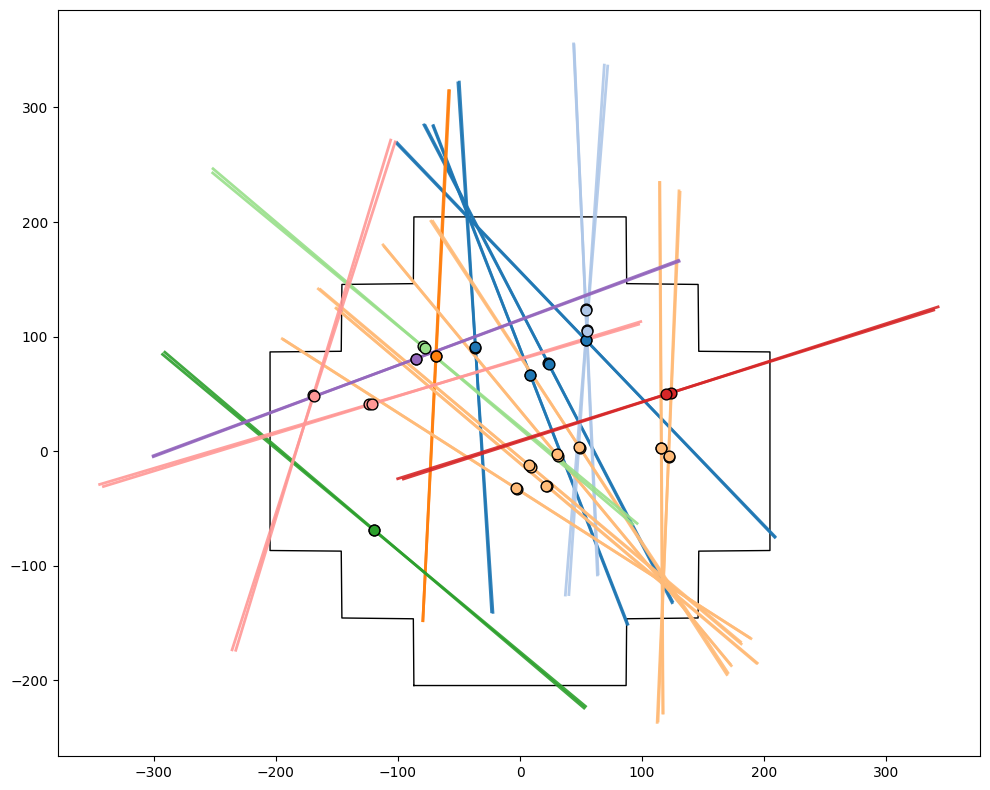

Salvate rette HG: 20
Salvate rette LG: 20
Salvati centroidi: 20


In [ ]:
####SIGMA CLIPPPPP################################
df_dt = df_dt[df_dt["shape"] > 5280425]   # come nel tuo codice
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

# ---------- strutture dove salvare i risultati ----------
rette_hg = []     # {"tel", "mc_run","event","p0","d"}
rette_lg = []     
centroidi = []    #  {"tel", "mc_run","event","hg":(x,y),"lg":(x,y)}

# ---------- loop sui telescopi / eventi (come nel tuo codice) ----------
for iv in range(len(df_dt)):

    itel = df_dt["TEL_ID"].iloc[iv]
    mc_run = df_dt["MCRUN"].iloc[iv] 
    event  = df_dt["EVENT"].iloc[iv]  

    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]

    #mask temporale / selezione pixel "buoni"
    pxmask = (hgev > 2400) & (ttpev < 255)

    # se non ci sono pixel validi, salta
    if not np.any(pxmask):
        continue

    # 2) estrai vettori pixel e pesi corrispondenti
    xx = x_pix[pxmask].flatten()
    yy = y_pix[pxmask].flatten()
    w_hg = hgev[pxmask].flatten()
    w_lg = lgev[pxmask].flatten()


    # 3) calcolo baricentro iniziale pesato (usiamo HG come riferimento iniziale)
    mx0 = np.average(xx, weights=w_hg)
    my0 = np.average(yy, weights=w_hg)

    # 4) distanza radiale di ogni pixel dal baricentro
    r = np.sqrt((xx - mx0)**2 + (yy - my0)**2)

    # 5) SIGMA-CLIP sulle distanze (1D) -> otteniamo low, high
    #    sigmaclip ritorna (clipped_array, lowbound, highbound)
    r_clip, low, high = sc.sigmaclip(r, low=3.0, high=3.0)
    keep = (r >= low) & (r <= high)

    # 6) pixel e pesi filtrati
    xx_sc   = xx[keep]
    yy_sc   = yy[keep]
    w_hg_sc = w_hg[keep]
    w_lg_sc = w_lg[keep]


    # 7) CENTROIDI pesati sui pixel sigmaclippati
    meanx_hg = np.average(xx_sc, weights=w_hg_sc)
    meany_hg = np.average(yy_sc, weights=w_hg_sc)
    meanx_lg = np.average(xx_sc, weights=w_lg_sc)
    meany_lg = np.average(yy_sc, weights=w_lg_sc)

    # 8) COVARIANZE pesate (sui pixel sigmaclippati)
    cov_hg = np.cov([xx_sc, yy_sc], aweights=w_hg_sc)
    cov_lg = np.cov([xx_sc, yy_sc], aweights=w_lg_sc)

    # 9) DIREZIONE principale: autovettore dell'autovalore maggiore
    eigvals_hg, eigvecs_hg = np.linalg.eigh(cov_hg)
    idx_hg = np.argmax(eigvals_hg)
    d_hg = eigvecs_hg[:, idx_hg]    # vettore direzione (normale)

    eigvals_lg, eigvecs_lg = np.linalg.eigh(cov_lg)
    idx_lg = np.argmax(eigvals_lg)
    d_lg = eigvecs_lg[:, idx_lg]
    # 10) salva le rette e i centroidi 
    rette_hg.append({
        "tel": itel,
        "mc_run": mc_run,
        "event": event,
        "p0": np.array([meanx_hg, meany_hg]),
        "d": d_hg
    })

    rette_lg.append({
        "tel": itel,
        "mc_run": mc_run,
        "event": event,
        "p0": np.array([meanx_lg, meany_lg]),
        "d": d_lg
    })

    centroidi.append({
        "tel": itel,
        "mc_run": mc_run,
        "event": event,
        "hg": (meanx_hg, meany_hg),
        "lg": (meanx_lg, meany_lg)
    })


# ---------- uso le rette salvate e coloro tutte le rette dello stesso (mc_run,event)
#               con lo stesso colore (semplice mappa via if-not-in-dict)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xfp, yfp, 'k-', linewidth=1)

xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag

# costruisco colori dalla colormap in modo semplice
color_cycle = plt.cm.tab20(np.linspace(0, 1, 20))
event_to_color = {}
ci = 0

# ordino le rette per avere colori più prevedibili (opzionale ma utile)
rette_combined = sorted(rette_hg + rette_lg, key=lambda r: (r["mc_run"], r["event"], r["tel"]))

for r in rette_combined:
    key = (r["mc_run"], r["event"])
    # assegna colore solo la prima volta che vedo la coppia (if semplice)
    if key not in event_to_color:
        event_to_color[key] = color_cycle[ci % len(color_cycle)]
        ci += 1

    col = event_to_color[key]

    p0 = r["p0"]
    d  = r["d"]

    # disegno centroide (colore dell'evento)
    ax.scatter(p0[0], p0[1], s=60, color=col, edgecolor="black", zorder=5)

    # disegno retta estesa di lunghezza L (in entrambe le direzioni)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color=col, linewidth=2, alpha=0.9)

plt.tight_layout()
plt.show()

# ---------- risultati riassuntivi
print("Salvate rette HG:", len(rette_hg))
print("Salvate rette LG:", len(rette_lg))
print("Salvati centroidi:", len(centroidi))

In [19]:

xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)

diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag          


rette_hg = []
rette_lg = []

for iv in range(len(df_dt)):

    itel = df_dt['TEL_ID'].iloc[iv]
    hgev = np.array(df_dt['HG'])[iv]
    lgev = np.array(df_dt['LG'])[iv]
    ttpev = np.array(df_dt['TTP'])[iv]

    pxmask = (hgev > 2400) & (ttpev < 255)

    meanx_hg = np.average(x_pix[pxmask].flatten(), weights=hgev[pxmask].flatten())
    meany_hg = np.average(y_pix[pxmask].flatten(), weights=hgev[pxmask].flatten())
    meanx_lg = np.average(x_pix[pxmask].flatten(), weights=lgev[pxmask].flatten())
    meany_lg = np.average(y_pix[pxmask].flatten(), weights=lgev[pxmask].flatten())

    cov_hg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],
                    aweights=hgev[pxmask].flatten())
    cov_lg = np.cov([x_pix[pxmask].flatten(), y_pix[pxmask].flatten()],
                    aweights=lgev[pxmask].flatten())

    l1_hg = (cov_hg[0,0]+cov_hg[1,1])/2 + np.sqrt(((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2)
    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])

    l1_lg = (cov_lg[0,0]+cov_lg[1,1])/2 + np.sqrt(((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2)
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel,
        "mc_run": df_dt['MCRUN'].iloc[iv],
        "event": df_dt['EVENT'].iloc[iv]
    })

    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel,
        "mc_run": df_dt['MCRUN'].iloc[iv],
        "event": df_dt['EVENT'].iloc[iv]
    })


# -------------------------------------------------------------
# INTERSEZIONI 
# -------------------------------------------------------------
def intersection(p1, d1, p2, d2):
    """
    p1, p2 = centroidi
    d1, d2 = direzioni 
    """
    A = np.array([d1, -d2]).T
    b = p2 - p1

    # determinante per capire se sono parallele
    det = np.linalg.det(A)
    if abs(det) < 1e-6:
        return None  
    # risolvi i parametri t
    t = np.linalg.solve(A, b)[0]

    # punto di intersezione
    return p1 + t * d1


# ####################################################
# INTERSEZIONI TRA TUTTE LE COPPIE DI RETTE HG
# ####################################################
N = len(rette_hg)
inters_hg = []

for i in range(N):
    p1 = rette_hg[i]["p0"]
    d1 = rette_hg[i]["d"]
    for j in range(i+1, N):
        p2 = rette_hg[j]["p0"]
        d2 = rette_hg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_hg.append(P)

inters_hg = np.array(inters_hg)
v_hg_nf = inters_hg.copy()   


# #####################################################
# INTERSEZIONI TRA TUTTE LE COPPIE DI RETTE LG
# ####################################################à
N = len(rette_lg)
inters_lg = []

for i in range(N):
    p1 = rette_lg[i]["p0"]
    d1 = rette_lg[i]["d"]
    for j in range(i+1, N):
        p2 = rette_lg[j]["p0"]
        d2 = rette_lg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_lg.append(P)

inters_lg = np.array(inters_lg)
v_lg_nf = inters_lg.copy()  
#####Filtro i punti troppo lontani (grezzo)###############################################
v_hg= np.array([p for p in v_hg_nf if  all(-1000 <= coord <= 1000 for coord in p)])
v_lg= np.array([p for p in v_lg_nf if  all(-1000 <= coord <= 1000 for coord in p)])






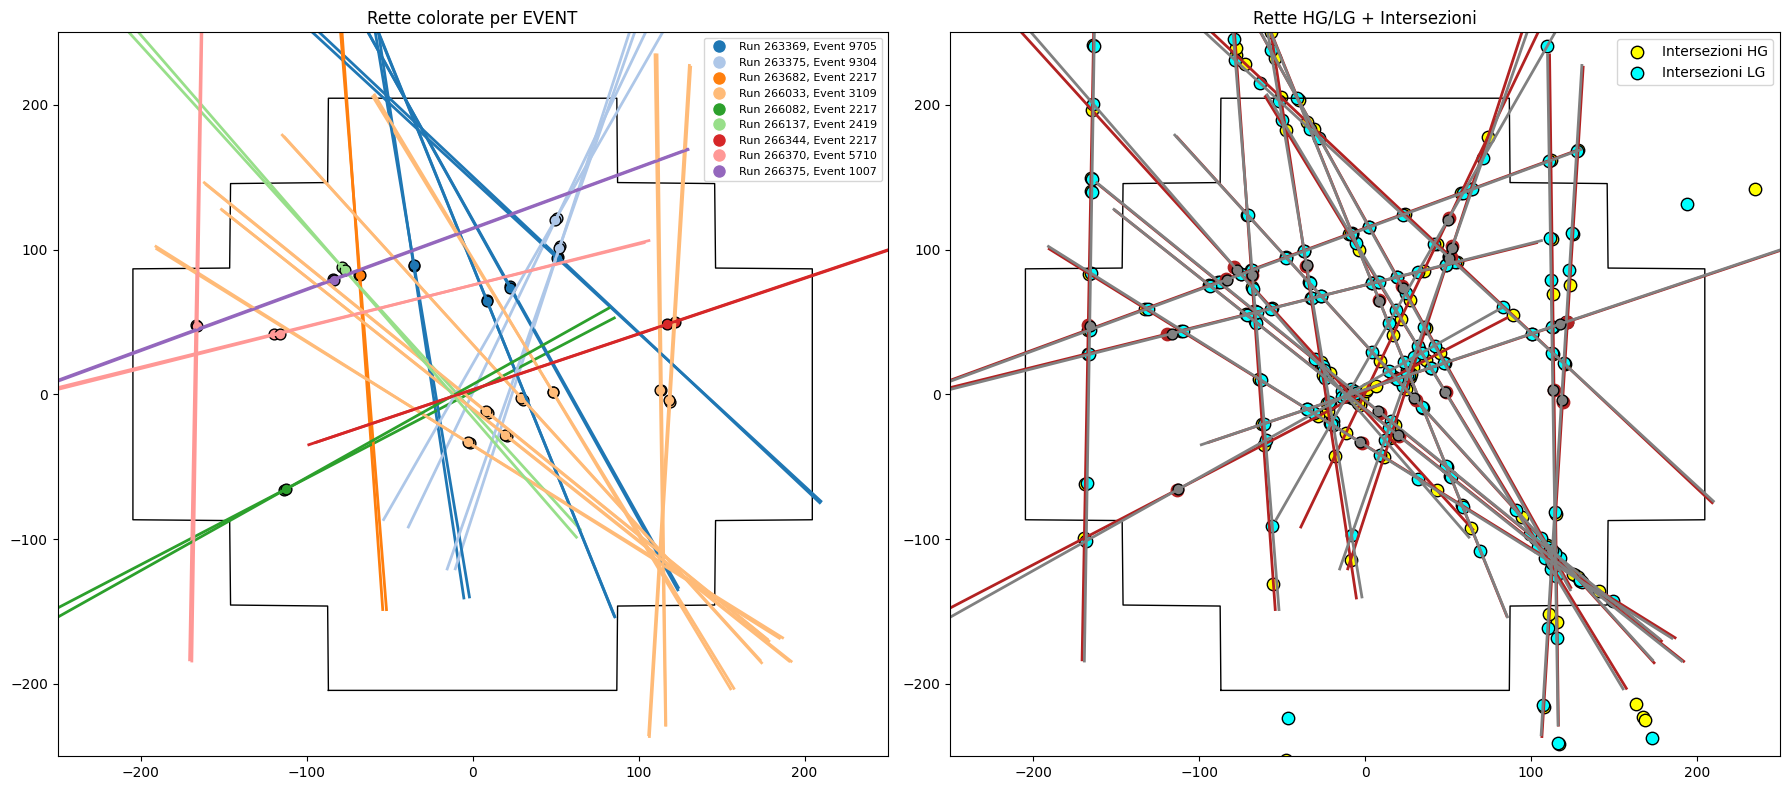

In [22]:
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# ---------- ----------
ax[0].plot(xfp, yfp, 'k-', linewidth=1)

event_to_color = {}
color_cycle = plt.cm.tab20(np.linspace(0, 1, 20))
ci = 0

for r in rette_hg + rette_lg:
    key = (r["mc_run"], r["event"])
    if key not in event_to_color:
        event_to_color[key] = color_cycle[ci % len(color_cycle)]
        ci += 1

    col = event_to_color[key]
    p0 = r["p0"]
    d  = r["d"]

    ax[0].scatter(p0[0], p0[1], color=col, s=60, edgecolor="black")
    ax[0].plot([p0[0]-L*d[0], p0[0]+L*d[0]],
               [p0[1]-L*d[1], p0[1]+L*d[1]], color=col, linewidth=2)

ax[0].set_title("Rette colorate per EVENT")
ax[0].set_xlim(-250,250)
ax[0].set_ylim(-250,250)

# Legenda EVENT
handles = [plt.Line2D([0],[0], marker='o', color='w',
                      markerfacecolor=event_to_color[k], markersize=10,
                      label=f"Run {k[0]}, Event {k[1]}")
           for k in list(event_to_color.keys())[:10]]
ax[0].legend(handles=handles, fontsize=8)

# ---------- PANNELLO DESTRO (HG rosso, LG grigio) ----------
ax[1].plot(xfp, yfp, 'k-', linewidth=1)

for r in rette_hg:
    p0, d = r["p0"], r["d"]
    ax[1].scatter(p0[0], p0[1], color="firebrick", s=80,zorder=2)
    ax[1].plot([p0[0]-L*d[0], p0[0]+L*d[0]],
               [p0[1]-L*d[1], p0[1]+L*d[1]], color="firebrick", linewidth=2)

for r in rette_lg:
    p0, d = r["p0"], r["d"]
    ax[1].scatter(p0[0], p0[1], color="grey", s=60, edgecolor="black",zorder=2)
    ax[1].plot([p0[0]-L*d[0], p0[0]+L*d[0]],
               [p0[1]-L*d[1], p0[1]+L*d[1]], color="grey", linewidth=2)

ax[1].scatter(v_hg[:,0], v_hg[:,1], s=80, color="yellow", edgecolor="black", label="Intersezioni HG")
ax[1].scatter(v_lg[:,0], v_lg[:,1], s=80, color="cyan",   edgecolor="black", label="Intersezioni LG")

ax[1].set_title("Rette HG/LG + Intersezioni")
ax[1].set_xlim(-250,250)
ax[1].set_ylim(-250,250)
ax[1].legend()

plt.tight_layout()
plt.show()